In [73]:
import torch, os, math, pickle, sys, random, time
from tqdm import tqdm
import torch.nn.init as init
import dgl,numpy as np
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader as GDataLoader, Batch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv, GraphConv, global_max_pool, GCNConv
from model import DialogueGCN_MELDModel, GraphNetwork_RGCN, GraphNetwork_GAT, \
GraphNetwork_GAT_EdgeFeat, GraphNetwork_GATv2, GraphNetwork_GATv2_EdgeFeat, GraphNetwork_RGAT, \
MatchingAttention, getDataLoaderAndLabels,GCNWithSkipConnections, GCNWithConcatenation
from model import DATASET_PATH
from torch.nn.utils.rnn import pad_sequence
from graph_context_dataset import GraphContextDataset
from sklearn.metrics import classification_report
from model import FCClassifier, MyNetwork, DATASET_PATH, MatchingAttention, RGCNWithGAT, \
RGATWithSkipConnections, EdgeGATWithGCN, EGATConv, EdgeGATWithSkipConnection,Edge2GATWithGCN
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
key=True
WINDOW_SIZE = 3

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [11]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH

In [12]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [13]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [14]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= WINDOW_SIZE) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [15]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

<h3> Data Preparation

<h4> Creating graph features from Train, Test and Validation sets

In [16]:
# checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
# encodedSpeakersTrain = []
# rangesTrain = []

# if not checkFile:
#     print("Run first the contextEncoder1 or 2 to generate this file")
# else:
#     with open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb") as file:
#         encodedSpeakersTrain, rangesTrain = pickle.load(file)

# checkFile = os.path.isfile("data/dump/" + dataset_path +"/adjListTrain.pkl")
# adjacencyListTrain = []

# if key:
#     adjacencyListTrain = get_all_adjacency_list(rangesTrain)
# else:
#     with open('data/dump/' + dataset_path + '/adjListTrain', "rb") as file:
#         adjacencyListTrain = pickle.load(file)

In [17]:
def getSpeakersAndRanges(file_path):
    checkFile = os.path.isfile(file_path)
    encodedSpeakers = []
#     ranges = []
    if not checkFile:
        print("Run first the contextEncoder1.5 to generate this file")
        return None
    else:
        with open(file_path, "rb") as file:
            encodedSpeakers, ranges = pickle.load(file)
        return encodedSpeakers, ranges
    
def getAdjacencyList(file_path, ranges):
    checkFile = os.path.isfile(file_path)
    adjacencyList = []

    if key:
        adjacencyList = get_all_adjacency_list(ranges)
    else:
        with open(file_path, "rb") as file:
            adjacencyList = pickle.load(file)
    
    return adjacencyList

In [18]:
file_path1 = "data/dump/" + dataset_path + "/speaker_encoder_train.pkl"
file_path2 = "data/dump/" + dataset_path + "/speaker_encoder_test.pkl"
file_path3 = "data/dump/" + dataset_path + "/speaker_encoder_dev.pkl"

encodedSpeakersTrain, rangesTrain = getSpeakersAndRanges(file_path1)
encodedSpeakersTest, rangesTest = getSpeakersAndRanges(file_path2)
encodedSpeakersDev, rangesDev = getSpeakersAndRanges(file_path3)

file_path1 = 'data/dump/' + dataset_path + '/adjListTrain'
file_path2 = 'data/dump/' + dataset_path + '/adjListTest'
file_path3 = 'data/dump/' + dataset_path + '/adjListDev'

adjacencyListTrain = getAdjacencyList(file_path1, rangesTrain)
adjacencyListTest = getAdjacencyList(file_path1, rangesTest)
adjacencyListDev = getAdjacencyList(file_path1, rangesDev)

In [19]:
file_path1 = 'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
file_path2 = 'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
file_path3 = 'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'

# Load the list from the file using pickle
def getFeatures(file_path):
    with open(file_path, 'rb') as file:
        emotions = pickle.load(file)
    return emotions

contextualEmbeddingsTrain = getFeatures(file_path1)
contextualEmbeddingsTest = getFeatures(file_path2)
contextualEmbeddingsDev = getFeatures(file_path3)

In [20]:
# print(contextualEmbeddingsTrain.shape, contextualEmbeddingsTest.shape, contextualEmbeddingsDev.shape)

In [21]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

edgeIndicesDev = get_all_adjacency_list(rangesDev)
edgeTypesDev = get_all_edge_type_list(edgeIndicesDev, encodedSpeakersDev)
edgeIndicesDev = get_all_adjacency_list(rangesDev, key=1)

In [22]:
len(edgeIndicesDev[0][0])

3

#### Train without relational features

In [23]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_dev = pickle.load(file)
y_dev = torch.tensor(y_dev)

In [24]:
y_tensor_train = [y_train[start:end + 1] for start, end in rangesTrain]
y_tensor_dev = [y_dev[start:end + 1] for start, end in rangesDev]
y_tensor_test = [y_test[start:end + 1] for start, end in rangesTest]

In [25]:
def getDataset(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
    dataset=[]
    for X, edges, Y, edgeTypes in zip(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
        graph_data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=torch.tensor(edges, dtype=torch.long),
            y=torch.tensor(Y, dtype=torch.long),
            edge_type = torch.tensor(edgeTypes, dtype=torch.long)
        )
        dataset.append(graph_data)
    return dataset

train_dataset = getDataset(contextualEmbeddingsTrain, edgeIndicesTrain, y_tensor_train, edgeTypesTrain)
dev_dataset = getDataset(contextualEmbeddingsDev, edgeIndicesDev, y_tensor_dev, edgeTypesDev)
test_dataset = getDataset(contextualEmbeddingsTest, edgeIndicesTest, y_tensor_test, edgeTypesTest)

train_loader = GDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = GDataLoader(dev_dataset, batch_size=1, shuffle=True)
test_loader = GDataLoader(test_dataset, batch_size=1, shuffle=True)

C:\Users\edayo\AppData\Local\Temp\ipykernel_5932\3524950887.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(X, dtype=torch.float),
C:\Users\edayo\AppData\Local\Temp\ipykernel_5932\3524950887.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edges, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_5932\3524950887.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(Y, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_5932\3524950887.py:8: UserWarning: To c

In [26]:
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)
    
label_decoder.values()

dict_values(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

In [27]:
def train_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_model(model_class, train_loader, val_loader, num_features, num_classes):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes)
        model, _, _, _, val_accuracies = train_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

def show_classification_report_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

no tuning

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.04it/s]


Epoch 1: Train Loss = 1.7979811015840959, Val Loss = 1.6400485457757625, Train Acc = 0.4848130841121495, Val Acc = 0.5157318741450069


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.23it/s]


Epoch 2: Train Loss = 1.8469491328382297, Val Loss = 2.5521520575198036, Train Acc = 0.5128504672897196, Val Acc = 0.5088919288645691


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.86it/s]


Epoch 3: Train Loss = 1.7216724603488611, Val Loss = 1.9617203909556675, Train Acc = 0.5349688473520249, Val Acc = 0.5232558139534884


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.93it/s]


Epoch 4: Train Loss = 1.735930909639137, Val Loss = 3.1911930801415886, Train Acc = 0.5350467289719626, Val Acc = 0.3385772913816689


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.21it/s]


Epoch 5: Train Loss = 1.8029725697696954, Val Loss = 2.0802038897089745, Train Acc = 0.5295171339563863, Val Acc = 0.5485636114911081


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 168.84it/s]


Epoch 6: Train Loss = 1.8629472157006528, Val Loss = 2.0276274187835277, Train Acc = 0.5333333333333333, Val Acc = 0.4357045143638851
Early stopping triggered


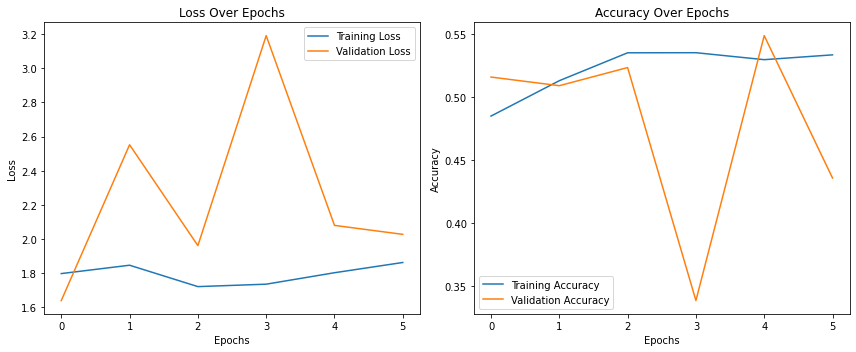

              precision    recall  f1-score   support

       anger       0.33      0.49      0.40       516
     disgust       0.00      0.00      0.00        99
        fear       0.05      0.22      0.09        60
         joy       0.60      0.34      0.44       495
     neutral       0.78      0.49      0.60      1615
     sadness       0.13      0.33      0.19       263
    surprise       0.44      0.56      0.49       352

    accuracy                           0.44      3400
   macro avg       0.33      0.35      0.31      3400
weighted avg       0.57      0.44      0.48      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [28]:
model = GCNWithSkipConnections(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)
show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
show_classification_report_model(model, test_loader)

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 206.31it/s]


Epoch 1: Train Loss = 1.7609916204328193, Val Loss = 2.509307787291376, Train Acc = 0.5293613707165109, Val Acc = 0.5437756497948016


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.71it/s]


Epoch 2: Train Loss = 1.6347193751483078, Val Loss = 2.2920169295217083, Train Acc = 0.550778816199377, Val Acc = 0.5266757865937073


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.18it/s]


Epoch 3: Train Loss = 1.5583255310865718, Val Loss = 2.5720063765498775, Train Acc = 0.5679906542056075, Val Acc = 0.42818057455540354


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:14<00:00, 149.21it/s]


Epoch 4: Train Loss = 1.5366290243116694, Val Loss = 2.6928510821734863, Train Acc = 0.5744548286604362, Val Acc = 0.5150478796169631


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.85it/s]


Epoch 5: Train Loss = 1.4821959716960784, Val Loss = 2.1692280081713022, Train Acc = 0.5784267912772586, Val Acc = 0.5027359781121751


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.12it/s]


Epoch 6: Train Loss = 1.4477540637074358, Val Loss = 2.5099066833077273, Train Acc = 0.5876168224299065, Val Acc = 0.5259917920656635


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.98it/s]


Epoch 7: Train Loss = 1.487621274388699, Val Loss = 2.3829823795274865, Train Acc = 0.5815420560747664, Val Acc = 0.5341997264021888


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.75it/s]


Epoch 8: Train Loss = 1.4097380307993228, Val Loss = 2.451980396632657, Train Acc = 0.5931464174454829, Val Acc = 0.46580027359781123


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.22it/s]


Epoch 9: Train Loss = 1.4379351899833577, Val Loss = 2.2313217788124113, Train Acc = 0.585981308411215, Val Acc = 0.493844049247606


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.00it/s]


Epoch 10: Train Loss = 1.3702571428816892, Val Loss = 2.372610716991713, Train Acc = 0.6003894080996884, Val Acc = 0.5259917920656635
Early stopping triggered


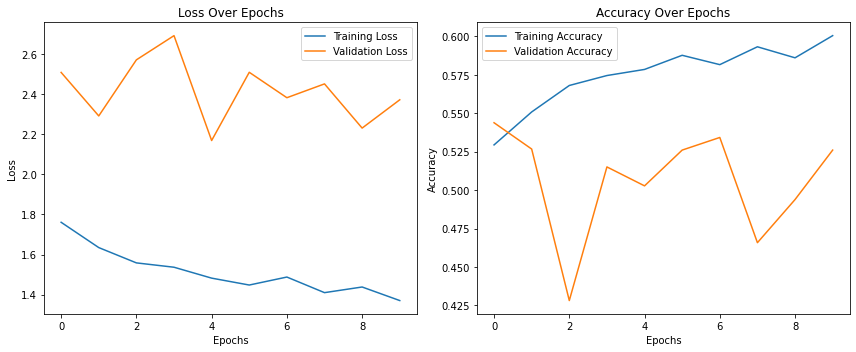

              precision    recall  f1-score   support

       anger       0.53      0.24      0.33       516
     disgust       0.67      0.04      0.08        99
        fear       0.20      0.05      0.08        60
         joy       0.36      0.66      0.46       495
     neutral       0.70      0.78      0.74      1615
     sadness       0.25      0.14      0.18       263
    surprise       0.53      0.41      0.46       352

    accuracy                           0.56      3400
   macro avg       0.46      0.33      0.33      3400
weighted avg       0.56      0.56      0.53      3400



In [29]:
model = GCNWithConcatenation(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_model(model, test_loader)

with tuning

In [30]:
best_model, best_params = tune_model(GCNWithSkipConnections, train_loader, val_loader, 768, 7)
show_classification_report_model(best_model, test_loader)

Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.99it/s]


Epoch 1: Train Loss = 107.1799961779076, Val Loss = 139.4957041853556, Train Acc = 0.41713395638629286, Val Acc = 0.5198358413132695


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.43it/s]


Epoch 2: Train Loss = 124.4086038856219, Val Loss = 114.14246130115174, Train Acc = 0.44797507788161994, Val Acc = 0.4883720930232558


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 161.76it/s]


Epoch 3: Train Loss = 122.10426156369061, Val Loss = 122.21436442534126, Train Acc = 0.4640965732087227, Val Acc = 0.5102599179206566


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 169.76it/s]


Epoch 4: Train Loss = 136.2849443723275, Val Loss = 179.9636816986181, Train Acc = 0.4719626168224299, Val Acc = 0.3796169630642955


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 168.36it/s]


Epoch 5: Train Loss = 133.60408387845115, Val Loss = 141.43444894265247, Train Acc = 0.4822429906542056, Val Acc = 0.45622435020519836


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 168.23it/s]


Epoch 6: Train Loss = 140.6648035375918, Val Loss = 170.44155155313456, Train Acc = 0.4858255451713396, Val Acc = 0.48632010943912446


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:14<00:00, 151.17it/s]


Epoch 7: Train Loss = 136.87443280745796, Val Loss = 120.38433589317181, Train Acc = 0.4940809968847352, Val Acc = 0.3748290013679891


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.65it/s]


Epoch 8: Train Loss = 140.4819524987457, Val Loss = 224.23259396199828, Train Acc = 0.4954828660436137, Val Acc = 0.454172366621067


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.75it/s]


Epoch 9: Train Loss = 145.16628382815495, Val Loss = 136.53395313963432, Train Acc = 0.49073208722741435, Val Acc = 0.4213406292749658


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 165.93it/s]


Epoch 10: Train Loss = 155.22952874180018, Val Loss = 313.0499925185133, Train Acc = 0.49485981308411214, Val Acc = 0.4432284541723666


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.47it/s]


Epoch 11: Train Loss = 134.15240931063457, Val Loss = 178.28756102654668, Train Acc = 0.4984423676012461, Val Acc = 0.4945280437756498


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.86it/s]


Epoch 12: Train Loss = 159.07356575612843, Val Loss = 263.3189690148389, Train Acc = 0.5013239875389408, Val Acc = 0.34199726402188785
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.33it/s]


Epoch 1: Train Loss = 99.2070633506682, Val Loss = 113.73352156161518, Train Acc = 0.4193146417445483, Val Acc = 0.3850889192886457


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.46it/s]


Epoch 2: Train Loss = 136.9964071156587, Val Loss = 162.47140663994563, Train Acc = 0.45638629283489096, Val Acc = 0.3734610123119015


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.83it/s]


Epoch 3: Train Loss = 126.24601335937173, Val Loss = 125.45089079215295, Train Acc = 0.4627725856697819, Val Acc = 0.49658002735978113


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.76it/s]


Epoch 4: Train Loss = 132.92230675723764, Val Loss = 154.4367682201985, Train Acc = 0.4742990654205608, Val Acc = 0.4008207934336525


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.42it/s]


Epoch 5: Train Loss = 141.04920394784364, Val Loss = 131.7795953905141, Train Acc = 0.4792834890965732, Val Acc = 0.326265389876881


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 168.60it/s]


Epoch 6: Train Loss = 136.95658612184107, Val Loss = 129.89099021622135, Train Acc = 0.48473520249221186, Val Acc = 0.4493844049247606


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 159.41it/s]


Epoch 7: Train Loss = 147.71287930610052, Val Loss = 223.72724216764354, Train Acc = 0.4855919003115265, Val Acc = 0.4904240766073871


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 165.66it/s]


Epoch 8: Train Loss = 144.01049825807178, Val Loss = 133.46169602831168, Train Acc = 0.4927570093457944, Val Acc = 0.44528043775649795


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 169.12it/s]


Epoch 9: Train Loss = 147.47258853345429, Val Loss = 126.59818070817877, Train Acc = 0.49727414330218067, Val Acc = 0.37277701778385774


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.80it/s]


Epoch 10: Train Loss = 131.81340386889786, Val Loss = 206.82254883691138, Train Acc = 0.4940031152647975, Val Acc = 0.5321477428180574


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.98it/s]


Epoch 11: Train Loss = 148.70876220659073, Val Loss = 117.02848428119384, Train Acc = 0.4955607476635514, Val Acc = 0.5157318741450069
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 207.87it/s]


Epoch 1: Train Loss = 1.204983143625712, Val Loss = 1.3465435058706337, Train Acc = 0.5875389408099688, Val Acc = 0.5506155950752394


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 166.31it/s]


Epoch 2: Train Loss = 1.0954444255455638, Val Loss = 1.3439456495145956, Train Acc = 0.6171339563862929, Val Acc = 0.5574555403556771


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.95it/s]


Epoch 3: Train Loss = 1.0557576932288981, Val Loss = 1.3082937362845297, Train Acc = 0.6172897196261682, Val Acc = 0.5574555403556771


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.27it/s]


Epoch 4: Train Loss = 1.0282457553065831, Val Loss = 1.2789785890529553, Train Acc = 0.6251557632398754, Val Acc = 0.5595075239398085


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 170.38it/s]


Epoch 5: Train Loss = 1.0025196163596033, Val Loss = 1.3138267724050416, Train Acc = 0.6344236760124611, Val Acc = 0.5725034199726402


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.39it/s]


Epoch 6: Train Loss = 0.977698535399395, Val Loss = 1.3351134276638428, Train Acc = 0.6375389408099689, Val Acc = 0.5690834473324213


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.69it/s]


Epoch 7: Train Loss = 0.9677554219238961, Val Loss = 1.364559293538332, Train Acc = 0.6401090342679128, Val Acc = 0.5704514363885089


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.01it/s]


Epoch 8: Train Loss = 0.9511247629777279, Val Loss = 1.3007821635274148, Train Acc = 0.6421339563862928, Val Acc = 0.5807113543091655


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.61it/s]


Epoch 9: Train Loss = 0.9285334950240482, Val Loss = 1.390443768924861, Train Acc = 0.6463395638629283, Val Acc = 0.5711354309165527
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.44it/s]


Epoch 1: Train Loss = 102.83849267365174, Val Loss = 78.93197072634857, Train Acc = 0.41495327102803736, Val Acc = 0.4487004103967168


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.90it/s]


Epoch 2: Train Loss = 127.04237573516754, Val Loss = 198.23295818285592, Train Acc = 0.44781931464174457, Val Acc = 0.34678522571819426


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.07it/s]


Epoch 3: Train Loss = 127.98400724737765, Val Loss = 227.49248176327458, Train Acc = 0.4649532710280374, Val Acc = 0.38303693570451436


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.08it/s]


Epoch 4: Train Loss = 126.17350984078593, Val Loss = 111.969997510911, Train Acc = 0.4767133956386293, Val Acc = 0.4904240766073871


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 168.19it/s]


Epoch 5: Train Loss = 134.89722704768766, Val Loss = 205.37154449973943, Train Acc = 0.48434579439252334, Val Acc = 0.27975376196990426


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 154.58it/s]


Epoch 6: Train Loss = 138.6535678092913, Val Loss = 211.6335285921512, Train Acc = 0.47710280373831776, Val Acc = 0.39740082079343364


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 163.63it/s]


Epoch 7: Train Loss = 138.28595818377022, Val Loss = 112.40333791101732, Train Acc = 0.48543613707165106, Val Acc = 0.4904240766073871


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 157.47it/s]


Epoch 8: Train Loss = 151.50941192748127, Val Loss = 182.85419746284475, Train Acc = 0.4931464174454829, Val Acc = 0.44528043775649795


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 166.75it/s]


Epoch 9: Train Loss = 143.93829721810587, Val Loss = 186.98342388259329, Train Acc = 0.4953271028037383, Val Acc = 0.4630642954856361


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 165.16it/s]


Epoch 10: Train Loss = 147.09271181159417, Val Loss = 207.23727659913538, Train Acc = 0.500233644859813, Val Acc = 0.512311901504788


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 168.72it/s]


Epoch 11: Train Loss = 147.52415937854113, Val Loss = 145.76172112022286, Train Acc = 0.502803738317757, Val Acc = 0.45622435020519836
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.82it/s]


Epoch 1: Train Loss = 1.1939322912962071, Val Loss = 1.2904620640255786, Train Acc = 0.5908878504672898, Val Acc = 0.5642954856361149


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.91it/s]


Epoch 2: Train Loss = 1.0970710197756826, Val Loss = 1.3702471368842655, Train Acc = 0.6152647975077882, Val Acc = 0.539671682626539


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.41it/s]


Epoch 3: Train Loss = 1.05800883007598, Val Loss = 1.3211871732716207, Train Acc = 0.6226635514018691, Val Acc = 0.5512995896032832


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.02it/s]


Epoch 4: Train Loss = 1.025822952443182, Val Loss = 1.3019579762937845, Train Acc = 0.6263239875389408, Val Acc = 0.5772913816689467


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.68it/s]


Epoch 5: Train Loss = 1.0057251383921268, Val Loss = 1.37852109513349, Train Acc = 0.6292834890965732, Val Acc = 0.5718194254445964


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.96it/s]


Epoch 6: Train Loss = 0.9796781684026226, Val Loss = 1.3308021521126783, Train Acc = 0.634968847352025, Val Acc = 0.5533515731874145


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.56it/s]


Epoch 7: Train Loss = 0.9565864424548906, Val Loss = 1.3635164434159244, Train Acc = 0.641822429906542, Val Acc = 0.5636114911080712


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.87it/s]


Epoch 8: Train Loss = 0.9457314517292953, Val Loss = 1.3629934319053536, Train Acc = 0.643380062305296, Val Acc = 0.5752393980848153


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.34it/s]


Epoch 9: Train Loss = 0.9319270622537091, Val Loss = 1.3968263176442297, Train Acc = 0.648208722741433, Val Acc = 0.5567715458276333


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.35it/s]


Epoch 10: Train Loss = 0.9139288162628266, Val Loss = 1.43449549652912, Train Acc = 0.6499221183800623, Val Acc = 0.5417236662106704


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.03it/s]


Epoch 11: Train Loss = 0.898724078369398, Val Loss = 1.4361534749330194, Train Acc = 0.6549844236760125, Val Acc = 0.5567715458276333
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5807113543091655


TypeError: show_classification_report_model() takes 2 positional arguments but 3 were given

In [33]:
show_classification_report_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger       0.48      0.37      0.42       516
     disgust       0.80      0.08      0.15        99
        fear       0.25      0.08      0.12        60
         joy       0.48      0.55      0.51       495
     neutral       0.68      0.89      0.77      1615
     sadness       0.38      0.12      0.18       263
    surprise       0.65      0.36      0.46       352

    accuracy                           0.61      3400
   macro avg       0.53      0.35      0.37      3400
weighted avg       0.59      0.61      0.57      3400



In [34]:
best_model, best_params = tune_model(GCNWithConcatenation, train_loader, val_loader, 768, 7)

show_classification_report_model(best_model, test_loader)

Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 212.10it/s]


Epoch 1: Train Loss = 12.893530041261764, Val Loss = 19.205395337796826, Train Acc = 0.48029595015576326, Val Acc = 0.4897400820793434


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 199.21it/s]


Epoch 2: Train Loss = 13.765115140632787, Val Loss = 13.276359110804561, Train Acc = 0.5176791277258567, Val Acc = 0.5047879616963065


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.69it/s]


Epoch 3: Train Loss = 12.52331473472306, Val Loss = 20.68193280635881, Train Acc = 0.5296728971962616, Val Acc = 0.5136798905608755


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.87it/s]


Epoch 4: Train Loss = 12.76365381671683, Val Loss = 18.939755135908555, Train Acc = 0.5296728971962616, Val Acc = 0.4179206566347469


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.90it/s]


Epoch 5: Train Loss = 12.191449781616953, Val Loss = 15.461288868045274, Train Acc = 0.5383956386292835, Val Acc = 0.5266757865937073


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.71it/s]


Epoch 6: Train Loss = 12.189116756699683, Val Loss = 23.66416482136975, Train Acc = 0.5452492211838006, Val Acc = 0.34131326949384405


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 196.33it/s]


Epoch 7: Train Loss = 12.241035977811455, Val Loss = 18.551289052955926, Train Acc = 0.5519470404984423, Val Acc = 0.44528043775649795
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 208.47it/s]


Epoch 1: Train Loss = 1.7092253929587227, Val Loss = 2.08016951157263, Train Acc = 0.5290498442367602, Val Acc = 0.48700410396716826


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.99it/s]


Epoch 2: Train Loss = 1.6046597312481026, Val Loss = 1.791114056646755, Train Acc = 0.5539719626168225, Val Acc = 0.542407660738714


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.69it/s]


Epoch 3: Train Loss = 1.5314018326332626, Val Loss = 3.088008491011957, Train Acc = 0.5725077881619938, Val Acc = 0.4493844049247606


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.97it/s]


Epoch 4: Train Loss = 1.5053961115862438, Val Loss = 2.1723245241713744, Train Acc = 0.5676791277258567, Val Acc = 0.5191518467852257


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.99it/s]


Epoch 5: Train Loss = 1.4989176628995295, Val Loss = 2.7304386388553583, Train Acc = 0.575778816199377, Val Acc = 0.49316005471956226


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.53it/s]


Epoch 6: Train Loss = 1.5078703764744206, Val Loss = 3.1498956955534934, Train Acc = 0.5767912772585669, Val Acc = 0.4432284541723666


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.10it/s]


Epoch 7: Train Loss = 1.4494425613891035, Val Loss = 2.2651579912253914, Train Acc = 0.5879283489096573, Val Acc = 0.49247606019151846
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 211.72it/s]


Epoch 1: Train Loss = 14.48142516836877, Val Loss = 23.78289301780972, Train Acc = 0.48419003115264797, Val Acc = 0.3850889192886457


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.33it/s]


Epoch 2: Train Loss = 13.205928657049306, Val Loss = 14.167008721399059, Train Acc = 0.5087227414330218, Val Acc = 0.40834473324213405


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.17it/s]


Epoch 3: Train Loss = 12.646613521035057, Val Loss = 20.287957596750363, Train Acc = 0.5269470404984423, Val Acc = 0.5150478796169631


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.71it/s]


Epoch 4: Train Loss = 12.49797311459563, Val Loss = 29.265475539395702, Train Acc = 0.5316978193146418, Val Acc = 0.47127222982216144


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.56it/s]


Epoch 5: Train Loss = 12.368415405644743, Val Loss = 24.45172168775618, Train Acc = 0.5468847352024923, Val Acc = 0.45006839945280436


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.15it/s]


Epoch 6: Train Loss = 12.673924569584464, Val Loss = 27.15206428652859, Train Acc = 0.5462616822429907, Val Acc = 0.3686730506155951


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.96it/s]


Epoch 7: Train Loss = 12.404549048606976, Val Loss = 19.92808389747544, Train Acc = 0.5447819314641744, Val Acc = 0.4890560875512996
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 224.11it/s]


Epoch 1: Train Loss = 1.1921449805023494, Val Loss = 1.279356227621988, Train Acc = 0.5910436137071651, Val Acc = 0.5704514363885089


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 205.37it/s]


Epoch 2: Train Loss = 1.0776983515368084, Val Loss = 1.305366975069046, Train Acc = 0.6162772585669782, Val Acc = 0.5772913816689467


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.43it/s]


Epoch 3: Train Loss = 1.0372002931949855, Val Loss = 1.288684173811365, Train Acc = 0.628582554517134, Val Acc = 0.5718194254445964


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.65it/s]


Epoch 4: Train Loss = 1.0112124928911388, Val Loss = 1.3100738767120572, Train Acc = 0.6336448598130842, Val Acc = 0.5772913816689467


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 199.97it/s]


Epoch 5: Train Loss = 0.9930500476358078, Val Loss = 1.3136611558634925, Train Acc = 0.6355140186915887, Val Acc = 0.5718194254445964


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 199.34it/s]


Epoch 6: Train Loss = 0.9739453962383171, Val Loss = 1.315555953372408, Train Acc = 0.640031152647975, Val Acc = 0.5683994528043775


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.10it/s]


Epoch 7: Train Loss = 0.957198663986357, Val Loss = 1.325216652577122, Train Acc = 0.6438473520249222, Val Acc = 0.5649794801641587


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 199.21it/s]


Epoch 8: Train Loss = 0.9460732469128238, Val Loss = 1.3795772520066412, Train Acc = 0.6492211838006231, Val Acc = 0.5725034199726402


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 196.02it/s]


Epoch 9: Train Loss = 0.9315286619601668, Val Loss = 1.3227895216188497, Train Acc = 0.6496105919003116, Val Acc = 0.5738714090287278


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.15it/s]


Epoch 10: Train Loss = 0.9164399678741272, Val Loss = 1.30722563766219, Train Acc = 0.6552180685358255, Val Acc = 0.5711354309165527


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.92it/s]


Epoch 11: Train Loss = 0.912202659566214, Val Loss = 1.3499043483494058, Train Acc = 0.6575545171339564, Val Acc = 0.5779753761969905
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 208.32it/s]


Epoch 1: Train Loss = 13.590510552342561, Val Loss = 14.538666750237399, Train Acc = 0.4777258566978193, Val Acc = 0.49863201094391246


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.53it/s]


Epoch 2: Train Loss = 12.436058746235755, Val Loss = 13.800096022367251, Train Acc = 0.5130841121495328, Val Acc = 0.45348837209302323


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.77it/s]


Epoch 3: Train Loss = 12.216275994144016, Val Loss = 14.740071022433128, Train Acc = 0.5301401869158878, Val Acc = 0.5205198358413132


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.79it/s]


Epoch 4: Train Loss = 12.664921853712709, Val Loss = 14.853211374572755, Train Acc = 0.5339563862928349, Val Acc = 0.4719562243502052


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.55it/s]


Epoch 5: Train Loss = 12.716637437140163, Val Loss = 16.596242488036705, Train Acc = 0.5400311526479751, Val Acc = 0.47058823529411764


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.01it/s]


Epoch 6: Train Loss = 12.506835432105257, Val Loss = 25.84349013569682, Train Acc = 0.5425233644859813, Val Acc = 0.5075239398084815


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.20it/s]


Epoch 7: Train Loss = 12.594791675805427, Val Loss = 24.45857077396308, Train Acc = 0.5499221183800623, Val Acc = 0.4384404924760602
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5779753761969905
              precision    recall  f1-score   support

       anger       0.50      0.41      0.45       516
     disgust       0.53      0.10      0.17        99
        fear       0.42      0.08      0.14        60
         joy       0.51      0.51      0.51       495
     neutral       0.70      0.87      0.78      1615
     sadness       0.45      0.09      0.15       263
    surprise       0.48      0.52      0.50       352

    accuracy                           0.62      3400
   macro avg       0.51      0.37      0.38      3400
weighted avg       0.59      0.62      0.58      3400



In [35]:
# model = GCNWithSkipConnections(num_features=768, num_classes=7)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []
# early_stop_threshold = 0.0001
# best_val_loss = float('inf')
# no_improve_epochs = 0
# max_no_improve_epochs = 5

# for epoch in range(25):
#     model.train()
#     train_loss = 0
#     correct_train = 0
#     total_train = 0
    
#     for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index)
#         loss = criterion(out, data.y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         preds = out.argmax(dim=1)
#         correct_train += (preds == data.y).sum().item()
#         total_train += data.y.size(0)
    
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(correct_train / total_train)
    
#     model.eval()
#     val_loss = 0
#     correct_val = 0
#     total_val = 0
    
#     with torch.no_grad():
#         for data in val_loader:
#             out = model(data.x, data.edge_index)
#             loss = criterion(out, data.y)
#             val_loss += loss.item()
            
#             preds = out.argmax(dim=1)
#             correct_val += (preds == data.y).sum().item()
#             total_val += data.y.size(0)
    
#     val_losses.append(val_loss / len(val_loader))
#     val_accuracies.append(correct_val / total_val)
    
#     print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")
    
#     if best_val_loss - val_losses[-1] < early_stop_threshold:
#         no_improve_epochs += 1
#         if no_improve_epochs >= max_no_improve_epochs:
#             print("Early stopping triggered")
#             break
#     else:
#         no_improve_epochs = 0
#         best_val_loss = val_losses[-1]

In [36]:
# # Plot learning curves
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Over Epochs')

# plt.tight_layout()
# plt.show()

In [37]:
# # Classification report on test set
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         preds = out.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(data.y.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

#### RGCN

In [38]:
def train_relational_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index , data.edge_type)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.edge_type)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_relation_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_relational_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_classification_report_relation_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_type)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 111.89it/s]


Epoch 1: Train Loss = 1.7920225948807826, Val Loss = 1.6253279987998583, Train Acc = 0.4971183800623053, Val Acc = 0.5294117647058824


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.91it/s]


Epoch 2: Train Loss = 1.8342383945468623, Val Loss = 1.7742645729057216, Train Acc = 0.5164330218068536, Val Acc = 0.5321477428180574


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.42it/s]


Epoch 3: Train Loss = 1.7837591165740883, Val Loss = 3.0552173623359757, Train Acc = 0.5218847352024922, Val Acc = 0.4377564979480164


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.91it/s]


Epoch 4: Train Loss = 1.7685784943430984, Val Loss = 2.778622484940893, Train Acc = 0.5329439252336449, Val Acc = 0.45143638850889195


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.45it/s]


Epoch 5: Train Loss = 1.7376743760328854, Val Loss = 2.606329705834354, Train Acc = 0.5353582554517134, Val Acc = 0.5047879616963065


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.26it/s]


Epoch 6: Train Loss = 1.7434974635020775, Val Loss = 1.733008893330892, Train Acc = 0.5383956386292835, Val Acc = 0.5253077975376197
Early stopping triggered


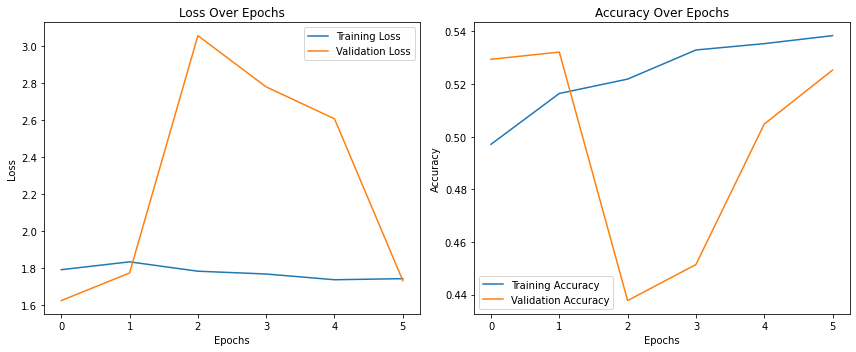

              precision    recall  f1-score   support

       anger       0.48      0.30      0.37       516
     disgust       0.43      0.06      0.11        99
        fear       0.00      0.00      0.00        60
         joy       0.54      0.36      0.43       495
     neutral       0.67      0.77      0.71      1615
     sadness       0.19      0.37      0.25       263
    surprise       0.47      0.51      0.49       352

    accuracy                           0.55      3400
   macro avg       0.40      0.34      0.34      3400
weighted avg       0.55      0.55      0.53      3400



In [39]:
model = RGCNWithGAT(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [40]:
best_model, best_params = tune_relation_model(RGCNWithGAT, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 116.04it/s]


Epoch 1: Train Loss = 1.2077851253147753, Val Loss = 1.3042317424659375, Train Acc = 0.5843457943925233, Val Acc = 0.5458276333789329


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.41it/s]


Epoch 2: Train Loss = 1.100747243701308, Val Loss = 1.3574916295431279, Train Acc = 0.6140965732087228, Val Acc = 0.5478796169630643


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.07it/s]


Epoch 3: Train Loss = 1.0563297381564216, Val Loss = 1.3028196017499323, Train Acc = 0.6204828660436137, Val Acc = 0.5499316005471956


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.99it/s]


Epoch 4: Train Loss = 1.0163843150466199, Val Loss = 1.3328120099449599, Train Acc = 0.622196261682243, Val Acc = 0.5704514363885089


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 103.58it/s]


Epoch 5: Train Loss = 0.9967633075184292, Val Loss = 1.3207580020582235, Train Acc = 0.6359813084112149, Val Acc = 0.5540355677154583


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.32it/s]


Epoch 6: Train Loss = 0.9688706628033995, Val Loss = 1.3799320679502907, Train Acc = 0.6399532710280373, Val Acc = 0.56703146374829


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.46it/s]


Epoch 7: Train Loss = 0.9545610965854764, Val Loss = 1.4113966462305851, Train Acc = 0.642601246105919, Val Acc = 0.5766073871409029


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.48it/s]


Epoch 8: Train Loss = 0.9383102979806373, Val Loss = 1.3025802605750936, Train Acc = 0.6458722741433022, Val Acc = 0.5595075239398085


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.21it/s]


Epoch 9: Train Loss = 0.9138588239490572, Val Loss = 1.3465900637899284, Train Acc = 0.6514018691588785, Val Acc = 0.5752393980848153


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.61it/s]


Epoch 10: Train Loss = 0.9023178377663027, Val Loss = 1.3678193735510662, Train Acc = 0.655373831775701, Val Acc = 0.5649794801641587


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.99it/s]


Epoch 11: Train Loss = 0.8793699176527163, Val Loss = 1.4541630096595597, Train Acc = 0.6570093457943925, Val Acc = 0.5615595075239398


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.76it/s]


Epoch 12: Train Loss = 0.8703011957447786, Val Loss = 1.4538385770525093, Train Acc = 0.6601246105919003, Val Acc = 0.5512995896032832


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.75it/s]


Epoch 13: Train Loss = 0.8549768630888408, Val Loss = 1.4766728876124102, Train Acc = 0.665809968847352, Val Acc = 0.5506155950752394
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 111.47it/s]


Epoch 1: Train Loss = 1.7695839039140993, Val Loss = 1.8917481922096124, Train Acc = 0.4937694704049844, Val Acc = 0.5369357045143639


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.62it/s]


Epoch 2: Train Loss = 1.7528858293349106, Val Loss = 1.8917608217439719, Train Acc = 0.5173676012461059, Val Acc = 0.4904240766073871


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.19it/s]


Epoch 3: Train Loss = 1.8311287851667164, Val Loss = 2.2458017275867017, Train Acc = 0.5279595015576324, Val Acc = 0.4856361149110807


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.14it/s]


Epoch 4: Train Loss = 1.7935395559250604, Val Loss = 1.8190894951285035, Train Acc = 0.5263239875389408, Val Acc = 0.4897400820793434


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.13it/s]


Epoch 5: Train Loss = 1.7662756013472274, Val Loss = 1.921323485844941, Train Acc = 0.5337227414330218, Val Acc = 0.5136798905608755


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.12it/s]


Epoch 6: Train Loss = 1.8841306848042552, Val Loss = 2.3894250801281522, Train Acc = 0.5341121495327102, Val Acc = 0.5027359781121751


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.12it/s]


Epoch 7: Train Loss = 1.7042526430378293, Val Loss = 2.237033379552196, Train Acc = 0.5445482866043614, Val Acc = 0.5116279069767442


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.35it/s]


Epoch 8: Train Loss = 1.8565904264269546, Val Loss = 2.101737693924871, Train Acc = 0.5492990654205607, Val Acc = 0.5266757865937073


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.19it/s]


Epoch 9: Train Loss = 1.829484537564371, Val Loss = 2.6960886220903677, Train Acc = 0.5414330218068536, Val Acc = 0.5020519835841313


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.08it/s]


Epoch 10: Train Loss = 1.7492884403977835, Val Loss = 3.6573921654886496, Train Acc = 0.5458722741433022, Val Acc = 0.46101231190150477


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.48it/s]


Epoch 11: Train Loss = 1.720168763474356, Val Loss = 3.0465545658850006, Train Acc = 0.5587227414330218, Val Acc = 0.33515731874145005


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.98it/s]


Epoch 12: Train Loss = 1.7818209428231495, Val Loss = 2.9303813286763787, Train Acc = 0.5493769470404984, Val Acc = 0.5205198358413132


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.13it/s]


Epoch 13: Train Loss = 1.7863236098401944, Val Loss = 4.086916954569622, Train Acc = 0.5551401869158878, Val Acc = 0.30984952120383036


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.04it/s]


Epoch 14: Train Loss = 1.776156274681814, Val Loss = 2.120786982405655, Train Acc = 0.5609034267912772, Val Acc = 0.5294117647058824
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 108.52it/s]


Epoch 1: Train Loss = 1.8237667595949325, Val Loss = 1.8400795890501251, Train Acc = 0.4931464174454829, Val Acc = 0.4021887824897401


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.21it/s]


Epoch 2: Train Loss = 1.7812693363222933, Val Loss = 1.811005813093787, Train Acc = 0.5214174454828661, Val Acc = 0.5191518467852257


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.12it/s]


Epoch 3: Train Loss = 1.734964463914555, Val Loss = 2.5625962195228094, Train Acc = 0.5264018691588785, Val Acc = 0.42954856361149113


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.87it/s]


Epoch 4: Train Loss = 1.8115606492782819, Val Loss = 3.702590700225577, Train Acc = 0.5323208722741433, Val Acc = 0.4897400820793434


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.91it/s]


Epoch 5: Train Loss = 1.7377429646198026, Val Loss = 2.411065993078605, Train Acc = 0.5356697819314642, Val Acc = 0.4466484268125855


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.39it/s]


Epoch 6: Train Loss = 1.747932808922045, Val Loss = 2.3719317431496973, Train Acc = 0.5400311526479751, Val Acc = 0.5232558139534884


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.98it/s]


Epoch 7: Train Loss = 1.799411703618083, Val Loss = 2.1824130158888657, Train Acc = 0.5356697819314642, Val Acc = 0.46169630642954856
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 108.69it/s]


Epoch 1: Train Loss = 1.762330159632418, Val Loss = 2.0581464968190564, Train Acc = 0.49517133956386294, Val Acc = 0.5116279069767442


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.31it/s]


Epoch 2: Train Loss = 1.7353037722134577, Val Loss = 1.8633909019193164, Train Acc = 0.5137071651090342, Val Acc = 0.4801641586867305


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 98.00it/s]


Epoch 3: Train Loss = 1.8394151242765584, Val Loss = 2.1652254948633964, Train Acc = 0.5190809968847352, Val Acc = 0.47127222982216144


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.77it/s]


Epoch 4: Train Loss = 1.7237732424367735, Val Loss = 2.0801714220654737, Train Acc = 0.5337227414330218, Val Acc = 0.5341997264021888


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.33it/s]


Epoch 5: Train Loss = 1.796896223003407, Val Loss = 2.6637304946504257, Train Acc = 0.5349688473520249, Val Acc = 0.45006839945280436


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.06it/s]


Epoch 6: Train Loss = 1.7207673553885225, Val Loss = 1.895392752951011, Train Acc = 0.5457165109034268, Val Acc = 0.5410396716826266


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.71it/s]


Epoch 7: Train Loss = 1.796705158022356, Val Loss = 1.9277755596131707, Train Acc = 0.5379283489096574, Val Acc = 0.5348837209302325
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 104.33it/s]


Epoch 1: Train Loss = 106.51978740171049, Val Loss = 95.45991436415162, Train Acc = 0.4106697819314642, Val Acc = 0.5109439124487004


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.06it/s]


Epoch 2: Train Loss = 118.39392521899306, Val Loss = 134.5384360904124, Train Acc = 0.45950155763239875, Val Acc = 0.4493844049247606


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.23it/s]


Epoch 3: Train Loss = 133.4390840132604, Val Loss = 149.02053603132566, Train Acc = 0.4680685358255452, Val Acc = 0.4158686730506156


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.84it/s]


Epoch 4: Train Loss = 125.30798583411148, Val Loss = 186.3458463412755, Train Acc = 0.467601246105919, Val Acc = 0.506155950752394


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.13it/s]


Epoch 5: Train Loss = 145.6750550246261, Val Loss = 204.15432195787628, Train Acc = 0.47998442367601246, Val Acc = 0.3625170998632011


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.97it/s]


Epoch 6: Train Loss = 136.7245905593508, Val Loss = 193.02941052384537, Train Acc = 0.4858255451713396, Val Acc = 0.3734610123119015


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.79it/s]


Epoch 7: Train Loss = 150.66892869715784, Val Loss = 239.30803577458417, Train Acc = 0.49182242990654207, Val Acc = 0.29411764705882354


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.86it/s]


Epoch 8: Train Loss = 131.82918360628074, Val Loss = 163.34916685967133, Train Acc = 0.49883177570093457, Val Acc = 0.506155950752394


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.20it/s]


Epoch 9: Train Loss = 143.7998969065351, Val Loss = 194.27825905079877, Train Acc = 0.49073208722741435, Val Acc = 0.41997264021887826


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.15it/s]


Epoch 10: Train Loss = 138.71478243730914, Val Loss = 199.773769875809, Train Acc = 0.4985981308411215, Val Acc = 0.38782489740082077


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.74it/s]


Epoch 11: Train Loss = 150.50000953110296, Val Loss = 175.46276924483203, Train Acc = 0.5052959501557632, Val Acc = 0.5280437756497948
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5766073871409029
              precision    recall  f1-score   support

       anger       0.49      0.44      0.46       516
     disgust       0.34      0.22      0.27        99
        fear       0.17      0.08      0.11        60
         joy       0.55      0.41      0.47       495
     neutral       0.71      0.85      0.77      1615
     sadness       0.48      0.05      0.10       263
    surprise       0.40      0.61      0.48       352

    accuracy                           0.60      3400
   macro avg       0.45      0.38      0.38      3400
weighted avg       0.59      0.60      0.57      3400



#### RGAT

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:19<00:00, 15.53it/s]


Epoch 1: Train Loss = 180.9415636763052, Val Loss = 51.529053684650634, Train Acc = 0.29750778816199375, Val Acc = 0.2414500683994528


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:18<00:00, 15.62it/s]


Epoch 2: Train Loss = 234.74904482122594, Val Loss = 94.05263158921842, Train Acc = 0.31121495327102805, Val Acc = 0.43433652530779754


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:18<00:00, 15.61it/s]


Epoch 3: Train Loss = 136.04898806793804, Val Loss = 61.31373628287327, Train Acc = 0.3516355140186916, Val Acc = 0.24897400820793433


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:16<00:00, 15.79it/s]


Epoch 4: Train Loss = 238.0564564298276, Val Loss = 69.57431692359626, Train Acc = 0.3509345794392523, Val Acc = 0.4117647058823529


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:15<00:00, 15.95it/s]


Epoch 5: Train Loss = 517.509421470391, Val Loss = 201.3250805864329, Train Acc = 0.3441588785046729, Val Acc = 0.49179206566347466


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:16<00:00, 15.82it/s]


Epoch 6: Train Loss = 215.68725562960935, Val Loss = 66.3700381144746, Train Acc = 0.37305295950155765, Val Acc = 0.454172366621067
Early stopping triggered


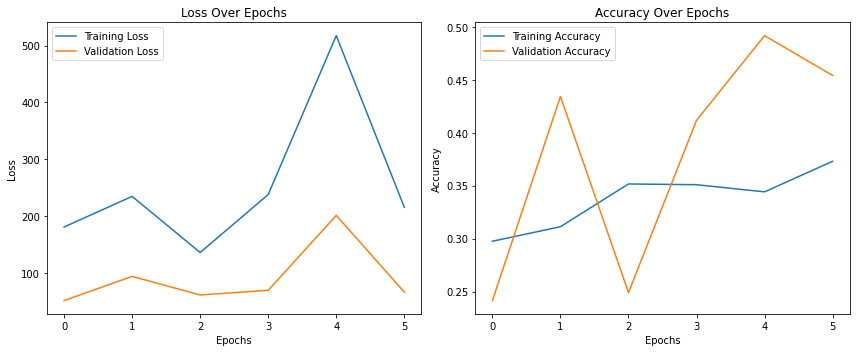

              precision    recall  f1-score   support

       anger       0.34      0.37      0.35       516
     disgust       0.07      0.08      0.08        99
        fear       0.00      0.00      0.00        60
         joy       0.35      0.28      0.31       495
     neutral       0.69      0.75      0.72      1615
     sadness       0.07      0.01      0.02       263
    surprise       0.27      0.40      0.32       352

    accuracy                           0.50      3400
   macro avg       0.26      0.27      0.26      3400
weighted avg       0.47      0.50      0.48      3400



In [41]:
model = RGATWithSkipConnections(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [42]:
best_model, best_params = tune_relation_model(RGATWithSkipConnections, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.28it/s]


Epoch 1: Train Loss = 1.7117644545958481, Val Loss = 1.8290171986376798, Train Acc = 0.4541277258566978, Val Acc = 0.4021887824897401


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.95it/s]


Epoch 2: Train Loss = 2.12809225804069, Val Loss = 1.8490416320661704, Train Acc = 0.40841121495327104, Val Acc = 0.4418604651162791


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 123.72it/s]


Epoch 3: Train Loss = 1.8515034263280945, Val Loss = 2.4127671964175534, Train Acc = 0.4382398753894081, Val Acc = 0.4493844049247606


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.70it/s]


Epoch 4: Train Loss = 2.1114645604751314, Val Loss = 1.7451610130844293, Train Acc = 0.41580996884735205, Val Acc = 0.45348837209302323


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.44it/s]


Epoch 5: Train Loss = 2.144701766133248, Val Loss = 1.653516501960931, Train Acc = 0.4116043613707165, Val Acc = 0.454172366621067


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.44it/s]


Epoch 6: Train Loss = 2.190783590721441, Val Loss = 1.6290415731293184, Train Acc = 0.4127725856697819, Val Acc = 0.4740082079343365


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.04it/s]


Epoch 7: Train Loss = 1.9589132633086086, Val Loss = 1.4071803416918824, Train Acc = 0.4355919003115265, Val Acc = 0.49726402188782487


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.65it/s]


Epoch 8: Train Loss = 2.065822287834669, Val Loss = 2.2562236764916666, Train Acc = 0.44299065420560746, Val Acc = 0.35499316005471954


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.84it/s]


Epoch 9: Train Loss = 2.196936397476302, Val Loss = 2.0277090243167346, Train Acc = 0.42577881619937696, Val Acc = 0.4575923392612859


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 119.31it/s]


Epoch 10: Train Loss = 2.067005759976167, Val Loss = 1.727256289934222, Train Acc = 0.43006230529595013, Val Acc = 0.42476060191518467


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.71it/s]


Epoch 11: Train Loss = 1.6925379252591854, Val Loss = 1.6193133840406382, Train Acc = 0.464797507788162, Val Acc = 0.460328317373461


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.11it/s]


Epoch 12: Train Loss = 2.086520551222013, Val Loss = 1.6942849606827453, Train Acc = 0.4362928348909657, Val Acc = 0.4630642954856361
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.40it/s]


Epoch 1: Train Loss = 1.3546034633630404, Val Loss = 1.3592681218490557, Train Acc = 0.541588785046729, Val Acc = 0.5314637482900136


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 132.35it/s]


Epoch 2: Train Loss = 1.2042387173217894, Val Loss = 1.3244219037117781, Train Acc = 0.5753115264797508, Val Acc = 0.5355677154582763


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.14it/s]


Epoch 3: Train Loss = 1.1548069672417585, Val Loss = 1.3499353441927169, Train Acc = 0.5885514018691589, Val Acc = 0.5280437756497948


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.83it/s]


Epoch 4: Train Loss = 1.1312892685575342, Val Loss = 1.303917796426901, Train Acc = 0.5985981308411215, Val Acc = 0.5533515731874145


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 136.39it/s]


Epoch 5: Train Loss = 1.1056562260897072, Val Loss = 1.289840942428068, Train Acc = 0.611214953271028, Val Acc = 0.5636114911080712


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.31it/s]


Epoch 6: Train Loss = 1.0862258171533339, Val Loss = 1.303625699836347, Train Acc = 0.6222741433021807, Val Acc = 0.5656634746922025


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 132.77it/s]


Epoch 7: Train Loss = 1.0745294835332229, Val Loss = 1.309155247843376, Train Acc = 0.6256230529595016, Val Acc = 0.5656634746922025


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.77it/s]


Epoch 8: Train Loss = 1.060991067560907, Val Loss = 1.2970899235319209, Train Acc = 0.6242211838006231, Val Acc = 0.5601915184678523


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.14it/s]


Epoch 9: Train Loss = 1.0491595867693562, Val Loss = 1.2888523278826918, Train Acc = 0.6286604361370717, Val Acc = 0.5745554035567716


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.88it/s]


Epoch 10: Train Loss = 1.0365352134513497, Val Loss = 1.314740872507294, Train Acc = 0.6304517133956387, Val Acc = 0.5629274965800274


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.29it/s]


Epoch 11: Train Loss = 1.028132179178539, Val Loss = 1.336180058259655, Train Acc = 0.6327881619937694, Val Acc = 0.5759233926128591


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.29it/s]


Epoch 12: Train Loss = 1.0141564323808308, Val Loss = 1.304540553647611, Train Acc = 0.6323208722741434, Val Acc = 0.560875512995896


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.86it/s]


Epoch 13: Train Loss = 1.0073527329473075, Val Loss = 1.3475491828112691, Train Acc = 0.6340342679127726, Val Acc = 0.5533515731874145


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 132.32it/s]


Epoch 14: Train Loss = 0.9968226906007018, Val Loss = 1.350049963041588, Train Acc = 0.638006230529595, Val Acc = 0.5383036935704515


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.45it/s]


Epoch 15: Train Loss = 0.9859061233572127, Val Loss = 1.3444492931063805, Train Acc = 0.6386292834890965, Val Acc = 0.5663474692202463


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.94it/s]


Epoch 16: Train Loss = 0.9767860618592412, Val Loss = 1.3315181071007693, Train Acc = 0.6449376947040498, Val Acc = 0.5601915184678523


Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.96it/s]


Epoch 17: Train Loss = 0.9661834204808757, Val Loss = 1.3954749163516142, Train Acc = 0.6444704049844237, Val Acc = 0.539671682626539


Epoch 18: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.40it/s]


Epoch 18: Train Loss = 0.9544572780771112, Val Loss = 1.3448522760084383, Train Acc = 0.6497663551401869, Val Acc = 0.5567715458276333


Epoch 19: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.47it/s]


Epoch 19: Train Loss = 0.9544637794024311, Val Loss = 1.3633138617293703, Train Acc = 0.6449376947040498, Val Acc = 0.5526675786593708
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.26it/s]


Epoch 1: Train Loss = 1.6668613448670064, Val Loss = 1.712346339225769, Train Acc = 0.45031152647975076, Val Acc = 0.4186046511627907


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 127.05it/s]


Epoch 2: Train Loss = 1.9696509382678886, Val Loss = 1.4815806833682237, Train Acc = 0.40132398753894083, Val Acc = 0.47332421340629277


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 136.28it/s]


Epoch 3: Train Loss = 2.0794523704633185, Val Loss = 1.6317376089316826, Train Acc = 0.4058411214953271, Val Acc = 0.40834473324213405


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 136.69it/s]


Epoch 4: Train Loss = 1.8675273653249154, Val Loss = 1.6768341107500924, Train Acc = 0.4163551401869159, Val Acc = 0.45075239398084815


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.91it/s]


Epoch 5: Train Loss = 2.05963705746237, Val Loss = 1.5884150870420315, Train Acc = 0.42095015576323985, Val Acc = 0.4883720930232558


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 138.87it/s]


Epoch 6: Train Loss = 1.8587307813827432, Val Loss = 1.5449895986528308, Train Acc = 0.4486760124610592, Val Acc = 0.46785225718194257


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 138.08it/s]


Epoch 7: Train Loss = 2.0216359554315675, Val Loss = 1.6192792886109264, Train Acc = 0.4328660436137072, Val Acc = 0.4849521203830369
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 138.50it/s]


Epoch 1: Train Loss = 1.5887575884694578, Val Loss = 1.5128728268323122, Train Acc = 0.4658878504672897, Val Acc = 0.46990424076607384


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.44it/s]


Epoch 2: Train Loss = 2.111823299954887, Val Loss = 2.0159607655334253, Train Acc = 0.3985981308411215, Val Acc = 0.43296853625171


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 139.34it/s]


Epoch 3: Train Loss = 1.8758380098561585, Val Loss = 1.731226806577157, Train Acc = 0.41736760124610595, Val Acc = 0.43980848153214774


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.10it/s]


Epoch 4: Train Loss = 2.384646383311526, Val Loss = 1.6817829385951713, Train Acc = 0.3996105919003115, Val Acc = 0.45964432284541723


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.91it/s]


Epoch 5: Train Loss = 1.8727318367886323, Val Loss = 1.5892780959054276, Train Acc = 0.43489096573208724, Val Acc = 0.48700410396716826


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.42it/s]


Epoch 6: Train Loss = 2.225469384779852, Val Loss = 1.787408580382665, Train Acc = 0.4084890965732087, Val Acc = 0.3960328317373461


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.13it/s]


Epoch 7: Train Loss = 2.330928036095456, Val Loss = 1.619456656622114, Train Acc = 0.3880841121495327, Val Acc = 0.46101231190150477


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.48it/s]


Epoch 8: Train Loss = 2.596330794763065, Val Loss = 1.7543823304689592, Train Acc = 0.3823208722741433, Val Acc = 0.45348837209302323


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 132.90it/s]


Epoch 9: Train Loss = 2.699620276867703, Val Loss = 1.7124243713087506, Train Acc = 0.3867601246105919, Val Acc = 0.45554035567715456


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.88it/s]


Epoch 10: Train Loss = 2.4448601367619296, Val Loss = 2.0542848968947376, Train Acc = 0.386993769470405, Val Acc = 0.31532147742818056


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.12it/s]


Epoch 11: Train Loss = 2.0094322814644934, Val Loss = 1.4928201727155181, Train Acc = 0.42624610591900314, Val Acc = 0.44596443228454175


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.55it/s]


Epoch 12: Train Loss = 1.9603782291662086, Val Loss = 1.7184003942029515, Train Acc = 0.43356697819314644, Val Acc = 0.4746922024623803


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.43it/s]


Epoch 13: Train Loss = 2.8134276535884797, Val Loss = 1.9463270604886391, Train Acc = 0.39026479750778814, Val Acc = 0.4363885088919289


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 119.65it/s]


Epoch 14: Train Loss = 2.4250963857475045, Val Loss = 1.844543663909038, Train Acc = 0.39244548286604364, Val Acc = 0.45143638850889195


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.93it/s]


Epoch 15: Train Loss = 2.1599390613572758, Val Loss = 2.658008887322137, Train Acc = 0.421417445482866, Val Acc = 0.43296853625171


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.84it/s]


Epoch 16: Train Loss = 2.334349654108896, Val Loss = 1.6822550687938929, Train Acc = 0.3971183800623053, Val Acc = 0.46169630642954856


Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.97it/s]


Epoch 17: Train Loss = 1.9173354080207732, Val Loss = 1.7448811762517802, Train Acc = 0.440809968847352, Val Acc = 0.47674418604651164


Epoch 18: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 132.22it/s]


Epoch 18: Train Loss = 2.435972437717336, Val Loss = 1.732885405531636, Train Acc = 0.41152647975077883, Val Acc = 0.4165526675786594


Epoch 19: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.88it/s]


Epoch 19: Train Loss = 2.0032015606059255, Val Loss = 1.723159090415747, Train Acc = 0.4307632398753894, Val Acc = 0.4575923392612859


Epoch 20: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.45it/s]


Epoch 20: Train Loss = 2.1026496744258245, Val Loss = 1.5721677464605481, Train Acc = 0.43909657320872275, Val Acc = 0.44596443228454175


Epoch 21: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.74it/s]


Epoch 21: Train Loss = 2.069524280545388, Val Loss = 1.6938963177027526, Train Acc = 0.43753894080996886, Val Acc = 0.3789329685362517
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 137.86it/s]


Epoch 1: Train Loss = 1.3296179568532993, Val Loss = 1.3526700991861247, Train Acc = 0.5446261682242991, Val Acc = 0.5430916552667578


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.56it/s]


Epoch 2: Train Loss = 1.1702603377626035, Val Loss = 1.3244102825928066, Train Acc = 0.5947040498442367, Val Acc = 0.5588235294117647


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 138.01it/s]


Epoch 3: Train Loss = 1.1346953246380307, Val Loss = 1.2913139767668866, Train Acc = 0.6065420560747663, Val Acc = 0.5683994528043775


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.26it/s]


Epoch 4: Train Loss = 1.110733078347726, Val Loss = 1.2758316367036766, Train Acc = 0.6153426791277259, Val Acc = 0.5704514363885089


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 137.05it/s]


Epoch 5: Train Loss = 1.0944956358987838, Val Loss = 1.280573547107202, Train Acc = 0.6167445482866044, Val Acc = 0.5656634746922025


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.46it/s]


Epoch 6: Train Loss = 1.079101933801064, Val Loss = 1.2854967654303269, Train Acc = 0.616588785046729, Val Acc = 0.5766073871409029


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 139.22it/s]


Epoch 7: Train Loss = 1.065894883902985, Val Loss = 1.331441005843657, Train Acc = 0.6197040498442368, Val Acc = 0.5615595075239398


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 137.70it/s]


Epoch 8: Train Loss = 1.0542924741334798, Val Loss = 1.3517121773075174, Train Acc = 0.6258566978193146, Val Acc = 0.551983584131327


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 140.26it/s]


Epoch 9: Train Loss = 1.0429209111706803, Val Loss = 1.2866401226846156, Train Acc = 0.6280373831775701, Val Acc = 0.5766073871409029


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 135.69it/s]


Epoch 10: Train Loss = 1.0354596435678778, Val Loss = 1.310467950820371, Train Acc = 0.6292834890965732, Val Acc = 0.5704514363885089


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 139.49it/s]


Epoch 11: Train Loss = 1.0263257434906403, Val Loss = 1.339855267431725, Train Acc = 0.633411214953271, Val Acc = 0.5779753761969905


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 137.26it/s]


Epoch 12: Train Loss = 1.0177708673920414, Val Loss = 1.2966053936630488, Train Acc = 0.6318535825545172, Val Acc = 0.5766073871409029


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 138.44it/s]


Epoch 13: Train Loss = 1.006375494601067, Val Loss = 1.3182525618760674, Train Acc = 0.6374610591900312, Val Acc = 0.5772913816689467


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.78it/s]


Epoch 14: Train Loss = 0.996658101627448, Val Loss = 1.3358751504578523, Train Acc = 0.6386292834890965, Val Acc = 0.5677154582763337
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5779753761969905
              precision    recall  f1-score   support

       anger       0.46      0.36      0.40       516
     disgust       0.00      0.00      0.00        99
        fear       0.00      0.00      0.00        60
         joy       0.54      0.46      0.49       495
     neutral       0.68      0.88      0.77      1615
     sadness       0.00      0.00      0.00       263
    surprise       0.43      0.59      0.50       352

    accuracy                           0.60      3400
   macro avg       0.30      0.33      0.31      3400
weighted avg       0.51      0.60      0.55      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

#### EdgeGAT

In [43]:
DIOLOG_ID = 0
startIdx, endIdx = rangesTrain[DIOLOG_ID][0], rangesTrain[DIOLOG_ID][1]

graph = dgl.graph((edgeIndicesTrain[DIOLOG_ID][0], edgeIndicesTrain[DIOLOG_ID][1]))
edge_feats = get_ohe(edgeTypesTrain[DIOLOG_ID])

# egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)

In [44]:
graph

Graph(num_nodes=14, num_edges=50,
      ndata_schemes={}
      edata_schemes={})

In [55]:
# class EGATConv(nn.Module):
#     def __init__(self,
#                  in_node_feats,
#                  in_edge_feats,
#                  out_node_feats,
#                  out_edge_feats,
#                  num_heads,
#                  bias=True,
#                  **kw_args):

#         super().__init__()
#         self._num_heads = num_heads
#         self._out_node_feats = out_node_feats
#         self._out_edge_feats = out_edge_feats
        
#         self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
#         self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
#         self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
#         self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
#         # Attention parameter
#         self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
#         if bias:
#             self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
#         else:
#             self.register_buffer('bias', None)
        
#         self.reset_parameters()

#     def reset_parameters(self):
#         torch.manual_seed(42)
#         gain = init.calculate_gain('relu')
#         init.xavier_normal_(self.fc_node.weight, gain=gain)
#         init.xavier_normal_(self.fc_ni.weight, gain=gain)
#         init.xavier_normal_(self.fc_fij.weight, gain=gain)
#         init.xavier_normal_(self.fc_nj.weight, gain=gain)
#         init.xavier_normal_(self.attn, gain=gain)
        
#         if self.bias is not None:
#             nn.init.constant_(self.bias, 0)

#     def forward(self, graph, nfeats, efeats, get_attention=False):
#         with graph.local_scope():
#             graph.edata['f'] = efeats
#             graph.ndata['h'] = nfeats
            
#             f_ni = self.fc_ni(nfeats)
#             f_nj = self.fc_nj(nfeats)
#             f_fij = self.fc_fij(efeats)
#             graph.srcdata.update({'f_ni' : f_ni})
#             graph.dstdata.update({'f_nj' : f_nj})
            
#             graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
#             f_out = graph.edata.pop('f_tmp') + f_fij
            
#             if self.bias is not None:
#                 f_out += self.bias
#             f_out = nn.functional.leaky_relu(f_out)
#             f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
#             e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
#             graph.edata['a'] = edge_softmax(graph, e)
#             graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
#             graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

#             h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
#             if get_attention:
#                 return h_out, f_out, graph.edata.pop('a')
#             else:
#                 return h_out, f_out
            
class EdgeGATWithSkipConnection(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithSkipConnection, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        # Add self-loops to edge_index and adjust edge_attr accordingly if needed
#         print(f"nfeats shape: {nfeats.shape}")
        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
#         print(f"X shape: {x.shape}")
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
#         print(x.shape, " vs ", x_skip.shape)
        x += x_skip  # Add skip connection
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [46]:
def train_egat_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0


        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x, edge_feats)

            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
                edge_feats = get_ohe(data.edge_type)
                out = model(graph, data.x , edge_feats)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_egat_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_egat_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_egat_model(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x , edge_feats)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.06it/s]


Epoch 1: Train Loss = 1.7504020978728982, Val Loss = 2.271514428073661, Train Acc = 0.5009345794392523, Val Acc = 0.47332421340629277


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:44<00:00, 48.36it/s]


Epoch 2: Train Loss = 1.8567011720409414, Val Loss = 2.1322024502170582, Train Acc = 0.5147196261682243, Val Acc = 0.5


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:42<00:00, 50.89it/s]


Epoch 3: Train Loss = 1.723649685377987, Val Loss = 2.494647419259504, Train Acc = 0.5267133956386293, Val Acc = 0.4883720930232558


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:42<00:00, 51.13it/s]


Epoch 4: Train Loss = 1.806435554212016, Val Loss = 2.819265988531212, Train Acc = 0.5350467289719626, Val Acc = 0.3789329685362517


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:42<00:00, 50.97it/s]


Epoch 5: Train Loss = 1.805192235013995, Val Loss = 1.9939863311355683, Train Acc = 0.5301401869158878, Val Acc = 0.5369357045143639


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:43<00:00, 49.85it/s]


Epoch 6: Train Loss = 1.7095468569941659, Val Loss = 2.0859656073015045, Train Acc = 0.5428348909657321, Val Acc = 0.49863201094391246


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:42<00:00, 50.31it/s]


Epoch 7: Train Loss = 1.7438893017717352, Val Loss = 2.518496273718625, Train Acc = 0.5448598130841121, Val Acc = 0.5020519835841313


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:42<00:00, 51.04it/s]


Epoch 8: Train Loss = 1.7636376373747764, Val Loss = 2.596965797748891, Train Acc = 0.5466510903426791, Val Acc = 0.4945280437756498


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 51.44it/s]


Epoch 9: Train Loss = 1.7518598323145624, Val Loss = 2.8211237472975714, Train Acc = 0.5448598130841121, Val Acc = 0.4835841313269494


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:45<00:00, 47.06it/s]


Epoch 10: Train Loss = 1.8056452825863138, Val Loss = 2.976989108460236, Train Acc = 0.5531931464174454, Val Acc = 0.5253077975376197
Early stopping triggered


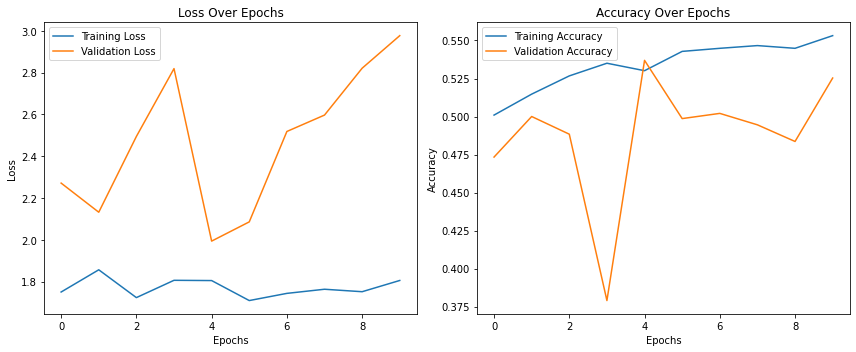

              precision    recall  f1-score   support

       anger       0.74      0.13      0.22       516
     disgust       0.00      0.00      0.00        99
        fear       0.00      0.00      0.00        60
         joy       0.41      0.49      0.45       495
     neutral       0.65      0.89      0.75      1615
     sadness       0.19      0.21      0.20       263
    surprise       0.56      0.35      0.43       352

    accuracy                           0.56      3400
   macro avg       0.36      0.29      0.29      3400
weighted avg       0.55      0.56      0.51      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [47]:
model = EdgeGATWithSkipConnection(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
# model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_egat_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_egat_model(model, test_loader)

In [48]:
best_model, best_params = tune_egat_model(EdgeGATWithSkipConnection, train_loader, val_loader, 768, 3, 4)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.49it/s]


Epoch 1: Train Loss = 1.2768335084568847, Val Loss = 1.3988055970933702, Train Acc = 0.5682242990654206, Val Acc = 0.5109439124487004


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.36it/s]


Epoch 2: Train Loss = 1.1866255420738727, Val Loss = 1.433817874888579, Train Acc = 0.5953271028037384, Val Acc = 0.5560875512995896


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.08it/s]


Epoch 3: Train Loss = 1.1585758693813761, Val Loss = 1.430759638051192, Train Acc = 0.5966510903426792, Val Acc = 0.49658002735978113


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.59it/s]


Epoch 4: Train Loss = 1.1250715151032502, Val Loss = 1.3455398406971384, Train Acc = 0.6042056074766355, Val Acc = 0.5540355677154583


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.05it/s]


Epoch 5: Train Loss = 1.1150441817111438, Val Loss = 1.4609479122001816, Train Acc = 0.6060747663551402, Val Acc = 0.5403556771545828


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 58.10it/s]


Epoch 6: Train Loss = 1.1154074507256695, Val Loss = 1.4590600419237658, Train Acc = 0.6083333333333333, Val Acc = 0.554719562243502


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.38it/s]


Epoch 7: Train Loss = 1.100101389428299, Val Loss = 1.363285060185525, Train Acc = 0.6096573208722741, Val Acc = 0.5636114911080712


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 55.12it/s]


Epoch 8: Train Loss = 1.0911240842779752, Val Loss = 1.5184646758975253, Train Acc = 0.6079439252336448, Val Acc = 0.5451436388508892


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.44it/s]


Epoch 9: Train Loss = 1.0810874122065595, Val Loss = 1.4844967243572076, Train Acc = 0.6140965732087228, Val Acc = 0.5232558139534884
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.21it/s]


Epoch 1: Train Loss = 1.2729548615998485, Val Loss = 1.3958773281839159, Train Acc = 0.5699376947040499, Val Acc = 0.5109439124487004


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.64it/s]


Epoch 2: Train Loss = 1.1883731952695935, Val Loss = 1.4435940555538291, Train Acc = 0.594392523364486, Val Acc = 0.554719562243502


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.13it/s]


Epoch 3: Train Loss = 1.158892437989858, Val Loss = 1.4193646288304418, Train Acc = 0.5958722741433021, Val Acc = 0.4993160054719562


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.78it/s]


Epoch 4: Train Loss = 1.124844018079306, Val Loss = 1.3464010959008226, Train Acc = 0.6042834890965733, Val Acc = 0.5526675786593708


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.02it/s]


Epoch 5: Train Loss = 1.1152750230420174, Val Loss = 1.4606145188074422, Train Acc = 0.6070872274143302, Val Acc = 0.539671682626539


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.22it/s]


Epoch 6: Train Loss = 1.1160086311606898, Val Loss = 1.4591392652993953, Train Acc = 0.6091121495327103, Val Acc = 0.5554035567715458


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.49it/s]


Epoch 7: Train Loss = 1.100966734098512, Val Loss = 1.3651676024965667, Train Acc = 0.6078660436137072, Val Acc = 0.5615595075239398


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.61it/s]


Epoch 8: Train Loss = 1.0906145370377798, Val Loss = 1.5179689755594288, Train Acc = 0.6083333333333333, Val Acc = 0.5437756497948016


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.20it/s]


Epoch 9: Train Loss = 1.0816162383520147, Val Loss = 1.4795043546085556, Train Acc = 0.6148753894080997, Val Acc = 0.5266757865937073


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.79it/s]


Epoch 10: Train Loss = 1.0727462185098342, Val Loss = 1.549324231332651, Train Acc = 0.6133956386292835, Val Acc = 0.5280437756497948


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.11it/s]


Epoch 11: Train Loss = 1.069049557057399, Val Loss = 1.5652715822612797, Train Acc = 0.6144859813084113, Val Acc = 0.4774281805745554


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.18it/s]


Epoch 12: Train Loss = 1.0540362406336634, Val Loss = 1.396768814408117, Train Acc = 0.6170560747663552, Val Acc = 0.5403556771545828


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.97it/s]


Epoch 13: Train Loss = 1.0538594418057645, Val Loss = 1.3722116660464694, Train Acc = 0.6186915887850467, Val Acc = 0.5499316005471956


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.73it/s]


Epoch 14: Train Loss = 1.046529608900245, Val Loss = 1.4315346946939826, Train Acc = 0.6204828660436137, Val Acc = 0.5362517099863201
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.29it/s]


Epoch 1: Train Loss = 5.198882766550251, Val Loss = 3.8419902793235248, Train Acc = 0.36534267912772583, Val Acc = 0.36320109439124487


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.63it/s]


Epoch 2: Train Loss = 6.636194725943624, Val Loss = 2.221915398117293, Train Acc = 0.41425233644859816, Val Acc = 0.4274965800273598


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.15it/s]


Epoch 3: Train Loss = 4.521794793222768, Val Loss = 11.480146444047568, Train Acc = 0.39400311526479753, Val Acc = 0.3119015047879617


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.21it/s]


Epoch 4: Train Loss = 5.179907963332014, Val Loss = 3.377324061685552, Train Acc = 0.39610591900311526, Val Acc = 0.42270861833105333


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.82it/s]


Epoch 5: Train Loss = 4.5392604317712255, Val Loss = 7.1345680040947475, Train Acc = 0.3883177570093458, Val Acc = 0.25239398084815323


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.65it/s]


Epoch 6: Train Loss = 5.55762569466111, Val Loss = 6.647105536154575, Train Acc = 0.39758566978193144, Val Acc = 0.23803009575923392


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.18it/s]


Epoch 7: Train Loss = 4.964428565539972, Val Loss = 4.9780192816699, Train Acc = 0.38294392523364484, Val Acc = 0.23255813953488372
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.00it/s]


Epoch 1: Train Loss = 1.2577192669389425, Val Loss = 1.2852618120334767, Train Acc = 0.5685358255451713, Val Acc = 0.5656634746922025


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.88it/s]


Epoch 2: Train Loss = 1.118147045339423, Val Loss = 1.2831055600334096, Train Acc = 0.6136292834890966, Val Acc = 0.5615595075239398


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.34it/s]


Epoch 3: Train Loss = 1.0745496291158445, Val Loss = 1.2729324439609493, Train Acc = 0.6242211838006231, Val Acc = 0.5656634746922025


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.82it/s]


Epoch 4: Train Loss = 1.04257291915861, Val Loss = 1.305789329994608, Train Acc = 0.6338785046728972, Val Acc = 0.5649794801641587


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.70it/s]


Epoch 5: Train Loss = 1.0241210688785132, Val Loss = 1.310262151228057, Train Acc = 0.6348909657320873, Val Acc = 0.5601915184678523


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.18it/s]


Epoch 6: Train Loss = 1.0077820180242674, Val Loss = 1.3155426795076992, Train Acc = 0.6391744548286604, Val Acc = 0.5677154582763337


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.10it/s]


Epoch 7: Train Loss = 0.9890108779590163, Val Loss = 1.4031315166796385, Train Acc = 0.6441588785046729, Val Acc = 0.5581395348837209


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.92it/s]


Epoch 8: Train Loss = 0.9777937643316195, Val Loss = 1.3262174727671123, Train Acc = 0.6456386292834891, Val Acc = 0.5663474692202463
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.69it/s]


Epoch 1: Train Loss = 1.2555854585953057, Val Loss = 1.300199758178658, Train Acc = 0.5715732087227414, Val Acc = 0.5656634746922025


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.60it/s]


Epoch 2: Train Loss = 1.1210201411835712, Val Loss = 1.2826258941105118, Train Acc = 0.6141744548286604, Val Acc = 0.5595075239398085


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.11it/s]


Epoch 3: Train Loss = 1.0842951524200746, Val Loss = 1.2725892149739795, Train Acc = 0.621183800623053, Val Acc = 0.5711354309165527


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.66it/s]


Epoch 4: Train Loss = 1.0565115528577869, Val Loss = 1.31578105510109, Train Acc = 0.6297507788161993, Val Acc = 0.5629274965800274


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.38it/s]


Epoch 5: Train Loss = 1.0402482987700583, Val Loss = 1.314077419401319, Train Acc = 0.6309190031152648, Val Acc = 0.5588235294117647


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.07it/s]


Epoch 6: Train Loss = 1.0286544771175141, Val Loss = 1.304767049200557, Train Acc = 0.6344236760124611, Val Acc = 0.5711354309165527


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.20it/s]


Epoch 7: Train Loss = 1.0125199646688998, Val Loss = 1.3962865848922068, Train Acc = 0.6370716510903427, Val Acc = 0.554719562243502


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.75it/s]


Epoch 8: Train Loss = 1.0038213638200735, Val Loss = 1.3094136461063668, Train Acc = 0.639018691588785, Val Acc = 0.5738714090287278
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5738714090287278


In [49]:
show_classification_report_egat_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger       0.55      0.28      0.37       516
     disgust       0.00      0.00      0.00        99
        fear       0.00      0.00      0.00        60
         joy       0.43      0.55      0.48       495
     neutral       0.70      0.88      0.78      1615
     sadness       0.49      0.11      0.18       263
    surprise       0.44      0.54      0.49       352

    accuracy                           0.60      3400
   macro avg       0.37      0.34      0.33      3400
weighted avg       0.56      0.60      0.56      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<h4> Creating "SAMPLE" graph features based on various graph networks

In [53]:
model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)

In [82]:
class EdgeGATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        
#         # EGAT layer 2
#         x, e = self.egat2(graph, x, e)
#         x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data
    
class Edge2GATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(Edge2GATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data

In [76]:
best_model, best_params = tune_egat_model(EdgeGATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.82it/s]


Epoch 1: Train Loss = 1.2860750870244508, Val Loss = 1.4607172443221013, Train Acc = 0.5592679127725857, Val Acc = 0.5259917920656635


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 74.64it/s]


Epoch 2: Train Loss = 1.194961230205027, Val Loss = 1.3892879154947069, Train Acc = 0.5922118380062306, Val Acc = 0.5560875512995896


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.45it/s]


Epoch 3: Train Loss = 1.1625571849755942, Val Loss = 1.3296441340474068, Train Acc = 0.5951713395638629, Val Acc = 0.5725034199726402


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.92it/s]


Epoch 4: Train Loss = 1.1379802895623639, Val Loss = 1.5115196308879941, Train Acc = 0.5965732087227414, Val Acc = 0.5369357045143639


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.69it/s]


Epoch 5: Train Loss = 1.124009552835142, Val Loss = 1.4621714006695483, Train Acc = 0.604595015576324, Val Acc = 0.5246238030095759


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.24it/s]


Epoch 6: Train Loss = 1.1119205547125872, Val Loss = 1.513658769759867, Train Acc = 0.604595015576324, Val Acc = 0.5389876880984952


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.85it/s]


Epoch 7: Train Loss = 1.101489134053527, Val Loss = 1.5652161133786042, Train Acc = 0.6089563862928349, Val Acc = 0.4781121751025992


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.99it/s]


Epoch 8: Train Loss = 1.0855861317424569, Val Loss = 1.3474019060532252, Train Acc = 0.6125389408099688, Val Acc = 0.5410396716826266
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 74.42it/s]


Epoch 1: Train Loss = 4.262986970561872, Val Loss = 2.8017992086501584, Train Acc = 0.37772585669781933, Val Acc = 0.4466484268125855


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.78it/s]


Epoch 2: Train Loss = 4.883557304542729, Val Loss = 8.285028428941992, Train Acc = 0.3708722741433022, Val Acc = 0.213406292749658


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.77it/s]


Epoch 3: Train Loss = 5.492363978645731, Val Loss = 4.075681016069871, Train Acc = 0.39057632398753894, Val Acc = 0.16757865937072502


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.50it/s]


Epoch 4: Train Loss = 5.737077516898519, Val Loss = 5.720894256883243, Train Acc = 0.37873831775700934, Val Acc = 0.478796169630643


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.26it/s]


Epoch 5: Train Loss = 4.206445827707941, Val Loss = 2.4210357886221674, Train Acc = 0.3806853582554517, Val Acc = 0.39192886456908343


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 76.66it/s]


Epoch 6: Train Loss = 4.555032789873977, Val Loss = 4.564304962938507, Train Acc = 0.385202492211838, Val Acc = 0.3091655266757866


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 74.20it/s]


Epoch 7: Train Loss = 5.018779134646657, Val Loss = 4.139419297142713, Train Acc = 0.3897196261682243, Val Acc = 0.23255813953488372


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 74.97it/s]


Epoch 8: Train Loss = 5.483694998158914, Val Loss = 2.8958026224678313, Train Acc = 0.39182242990654204, Val Acc = 0.36388508891928867


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 69.78it/s]


Epoch 9: Train Loss = 4.337702953592408, Val Loss = 5.064085429554598, Train Acc = 0.40475077881619936, Val Acc = 0.42339261285909713


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 69.73it/s]


Epoch 10: Train Loss = 4.7323873208627445, Val Loss = 4.278252324121261, Train Acc = 0.3980529595015576, Val Acc = 0.31874145006839943
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.30it/s]


Epoch 1: Train Loss = 1.2694630256129635, Val Loss = 1.3492685844638834, Train Acc = 0.5713395638629284, Val Acc = 0.5512995896032832


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 79.10it/s]


Epoch 2: Train Loss = 1.127479857304651, Val Loss = 1.2797293575894502, Train Acc = 0.6134735202492212, Val Acc = 0.5909712722298222


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.26it/s]


Epoch 3: Train Loss = 1.083552153017027, Val Loss = 1.3430006386194793, Train Acc = 0.6241433021806854, Val Acc = 0.5738714090287278


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 77.22it/s]


Epoch 4: Train Loss = 1.0603913085207481, Val Loss = 1.302969704154465, Train Acc = 0.6264018691588785, Val Acc = 0.5656634746922025


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.31it/s]


Epoch 5: Train Loss = 1.0417616843194184, Val Loss = 1.3079663918802031, Train Acc = 0.6299065420560748, Val Acc = 0.5656634746922025


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 75.30it/s]


Epoch 6: Train Loss = 1.0288933315969728, Val Loss = 1.2805820937233943, Train Acc = 0.631619937694704, Val Acc = 0.5841313269493844


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.86it/s]


Epoch 7: Train Loss = 1.0133786028764142, Val Loss = 1.3174339062361806, Train Acc = 0.6389408099688474, Val Acc = 0.5690834473324213
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 77.81it/s]


Epoch 1: Train Loss = 1.2886698159354704, Val Loss = 1.4736084340347184, Train Acc = 0.5574766355140187, Val Acc = 0.5225718194254446


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.00it/s]


Epoch 2: Train Loss = 1.2004881222275328, Val Loss = 1.3885093220958002, Train Acc = 0.589797507788162, Val Acc = 0.551983584131327


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.74it/s]


Epoch 3: Train Loss = 1.1627638153205797, Val Loss = 1.3290659840046255, Train Acc = 0.5978193146417445, Val Acc = 0.5745554035567716


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.29it/s]


Epoch 4: Train Loss = 1.1382113871132282, Val Loss = 1.519383471003837, Train Acc = 0.5964953271028037, Val Acc = 0.5341997264021888


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.99it/s]


Epoch 5: Train Loss = 1.1252126361950543, Val Loss = 1.4538524259985597, Train Acc = 0.6027258566978193, Val Acc = 0.53077975376197


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.04it/s]


Epoch 6: Train Loss = 1.1106122153173028, Val Loss = 1.4997140310670214, Train Acc = 0.6032710280373832, Val Acc = 0.5389876880984952


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.37it/s]


Epoch 7: Train Loss = 1.102637445356231, Val Loss = 1.5806117523047658, Train Acc = 0.6056853582554517, Val Acc = 0.47058823529411764


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.88it/s]


Epoch 8: Train Loss = 1.0848566121533858, Val Loss = 1.3577373429856918, Train Acc = 0.6097352024922118, Val Acc = 0.5383036935704515


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.70it/s]


Epoch 9: Train Loss = 1.080233537770066, Val Loss = 1.3656220146903286, Train Acc = 0.6140186915887851, Val Acc = 0.5540355677154583


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.16it/s]


Epoch 10: Train Loss = 1.0703404772716263, Val Loss = 1.4080880398206688, Train Acc = 0.6155763239875389, Val Acc = 0.5430916552667578


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.56it/s]


Epoch 11: Train Loss = 1.070844905440161, Val Loss = 1.3766332644210368, Train Acc = 0.6137850467289719, Val Acc = 0.551983584131327


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 79.78it/s]


Epoch 12: Train Loss = 1.0576428908953892, Val Loss = 1.394353660830745, Train Acc = 0.6152647975077882, Val Acc = 0.5232558139534884


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.01it/s]


Epoch 13: Train Loss = 1.0432436627247457, Val Loss = 1.4083912095261946, Train Acc = 0.6188473520249221, Val Acc = 0.5403556771545828
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.49it/s]


Epoch 1: Train Loss = 1.2703355590054006, Val Loss = 1.351526957957281, Train Acc = 0.5709501557632399, Val Acc = 0.5499316005471956


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.28it/s]


Epoch 2: Train Loss = 1.12554368641124, Val Loss = 1.2830024864386629, Train Acc = 0.611993769470405, Val Acc = 0.5868673050615595


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.24it/s]


Epoch 3: Train Loss = 1.0787885117654998, Val Loss = 1.3637944027402058, Train Acc = 0.6239875389408099, Val Acc = 0.5663474692202463


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.69it/s]


Epoch 4: Train Loss = 1.0552773524386188, Val Loss = 1.3344398939775095, Train Acc = 0.6265576323987538, Val Acc = 0.5711354309165527


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.40it/s]


Epoch 5: Train Loss = 1.035465291271814, Val Loss = 1.3093451297393552, Train Acc = 0.6303738317757009, Val Acc = 0.5649794801641587


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.67it/s]


Epoch 6: Train Loss = 1.0193069283264102, Val Loss = 1.2780146301344588, Train Acc = 0.6350467289719626, Val Acc = 0.5759233926128591


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.60it/s]


Epoch 7: Train Loss = 1.0039281951573988, Val Loss = 1.3068080341098485, Train Acc = 0.6394080996884736, Val Acc = 0.5690834473324213


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.80it/s]


Epoch 8: Train Loss = 0.9851016319348236, Val Loss = 1.3095478899363013, Train Acc = 0.6444704049844237, Val Acc = 0.5690834473324213


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.15it/s]


Epoch 9: Train Loss = 0.9744094312553191, Val Loss = 1.2955121141616945, Train Acc = 0.6471183800623053, Val Acc = 0.5690834473324213


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.20it/s]


Epoch 10: Train Loss = 0.9610587209376886, Val Loss = 1.3345412323665289, Train Acc = 0.6495327102803738, Val Acc = 0.5683994528043775


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.63it/s]


Epoch 11: Train Loss = 0.9508790537119947, Val Loss = 1.3228446940787963, Train Acc = 0.6515576323987539, Val Acc = 0.56703146374829


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.21it/s]


Epoch 12: Train Loss = 0.9419992260212354, Val Loss = 1.3356668669316503, Train Acc = 0.6544392523364486, Val Acc = 0.5615595075239398


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.70it/s]


Epoch 13: Train Loss = 0.9282730023928538, Val Loss = 1.3783017011980216, Train Acc = 0.6587227414330218, Val Acc = 0.5348837209302325


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.17it/s]


Epoch 14: Train Loss = 0.9257890715996769, Val Loss = 1.4055142803738514, Train Acc = 0.6568535825545171, Val Acc = 0.5198358413132695


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.58it/s]


Epoch 15: Train Loss = 0.9122636485090306, Val Loss = 1.3963473925298011, Train Acc = 0.664797507788162, Val Acc = 0.5629274965800274


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.87it/s]


Epoch 16: Train Loss = 0.9053936977051543, Val Loss = 1.3573473061952326, Train Acc = 0.6663551401869159, Val Acc = 0.5492476060191519
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5909712722298222
              precision    recall  f1-score   support

       anger       0.46      0.60      0.52       516
     disgust       0.00      0.00      0.00        99
        fear       0.00      0.00      0.00        60
         joy       0.53      0.52      0.52       495
     neutral       0.71      0.86      0.78      1615
     sadness       0.44      0.14      0.21       263
    surprise       0.64      0.39      0.49       352

    accuracy                           0.63      3400
   macro avg       0.40      0.36      0.36      3400
weighted avg       0.59      0.63      0.59      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [83]:
best_model, best_params = tune_egat_model(Edge2GATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.11it/s]


Epoch 1: Train Loss = 1.26765128349092, Val Loss = 1.4798820192477218, Train Acc = 0.5707165109034268, Val Acc = 0.5328317373461012


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.92it/s]


Epoch 2: Train Loss = 1.1920177786447177, Val Loss = 1.399015532447784, Train Acc = 0.5933021806853582, Val Acc = 0.5554035567715458


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.85it/s]


Epoch 3: Train Loss = 1.1613342048690862, Val Loss = 1.3303883498603548, Train Acc = 0.5963395638629283, Val Acc = 0.5718194254445964


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.95it/s]


Epoch 4: Train Loss = 1.139457017329901, Val Loss = 1.502632104660626, Train Acc = 0.5959501557632398, Val Acc = 0.5355677154582763


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.98it/s]


Epoch 5: Train Loss = 1.1235442401789544, Val Loss = 1.4589030502433027, Train Acc = 0.6031152647975078, Val Acc = 0.5232558139534884


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.68it/s]


Epoch 6: Train Loss = 1.109789582554044, Val Loss = 1.5099040977622349, Train Acc = 0.6045171339563863, Val Acc = 0.5444596443228454


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.20it/s]


Epoch 7: Train Loss = 1.1022962878182254, Val Loss = 1.5721529686616527, Train Acc = 0.606619937694704, Val Acc = 0.478796169630643


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.87it/s]


Epoch 8: Train Loss = 1.083671721172976, Val Loss = 1.3689742396827098, Train Acc = 0.6117601246105919, Val Acc = 0.539671682626539


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.65it/s]


Epoch 9: Train Loss = 1.079783510966485, Val Loss = 1.3626489339051424, Train Acc = 0.611993769470405, Val Acc = 0.551983584131327


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.58it/s]


Epoch 10: Train Loss = 1.070309471576992, Val Loss = 1.4066938503955801, Train Acc = 0.6171339563862929, Val Acc = 0.5526675786593708


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.96it/s]


Epoch 11: Train Loss = 1.0711134324126221, Val Loss = 1.379236405480791, Train Acc = 0.6118380062305296, Val Acc = 0.5485636114911081


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.77it/s]


Epoch 12: Train Loss = 1.0580218081164208, Val Loss = 1.3814014718212464, Train Acc = 0.6140965732087228, Val Acc = 0.5266757865937073


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.51it/s]


Epoch 13: Train Loss = 1.0427416926200277, Val Loss = 1.4039859942815922, Train Acc = 0.6204828660436137, Val Acc = 0.542407660738714
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.37it/s]


Epoch 1: Train Loss = 1.266963955304689, Val Loss = 1.4781895326795402, Train Acc = 0.5709501557632399, Val Acc = 0.533515731874145


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.41it/s]


Epoch 2: Train Loss = 1.1918051502926068, Val Loss = 1.4007624092546327, Train Acc = 0.5933800623052959, Val Acc = 0.5554035567715458


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.06it/s]


Epoch 3: Train Loss = 1.1610019974419157, Val Loss = 1.3303778911837274, Train Acc = 0.5964953271028037, Val Acc = 0.5718194254445964


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.61it/s]


Epoch 4: Train Loss = 1.1398269551836333, Val Loss = 1.5021568741373441, Train Acc = 0.5957165109034268, Val Acc = 0.5362517099863201


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.87it/s]


Epoch 5: Train Loss = 1.123613596197942, Val Loss = 1.4594034076150921, Train Acc = 0.6031931464174455, Val Acc = 0.5259917920656635


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.11it/s]


Epoch 6: Train Loss = 1.1096429193228552, Val Loss = 1.5081990947326025, Train Acc = 0.6042834890965733, Val Acc = 0.5410396716826266


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.43it/s]


Epoch 7: Train Loss = 1.1023751917295157, Val Loss = 1.572328939344044, Train Acc = 0.6068535825545172, Val Acc = 0.4794801641586867


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.07it/s]


Epoch 8: Train Loss = 1.0836593789572362, Val Loss = 1.3698278681823501, Train Acc = 0.6116822429906542, Val Acc = 0.5403556771545828
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.60it/s]


Epoch 1: Train Loss = 1.2670771131705907, Val Loss = 1.3340576740602652, Train Acc = 0.5771028037383178, Val Acc = 0.5560875512995896


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.91it/s]


Epoch 2: Train Loss = 1.1266109497424353, Val Loss = 1.2815051358883027, Train Acc = 0.6139408099688474, Val Acc = 0.5841313269493844


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.73it/s]


Epoch 3: Train Loss = 1.085552526494764, Val Loss = 1.3414010021421645, Train Acc = 0.624766355140187, Val Acc = 0.5690834473324213


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.70it/s]


Epoch 4: Train Loss = 1.0647266574048748, Val Loss = 1.296923364961037, Train Acc = 0.6274143302180686, Val Acc = 0.5704514363885089


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.25it/s]


Epoch 5: Train Loss = 1.0472231477723215, Val Loss = 1.3080429957972632, Train Acc = 0.6304517133956387, Val Acc = 0.5567715458276333


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.62it/s]


Epoch 6: Train Loss = 1.0365408397615992, Val Loss = 1.267936188382683, Train Acc = 0.632398753894081, Val Acc = 0.5800273597811217


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.53it/s]


Epoch 7: Train Loss = 1.023458274201214, Val Loss = 1.3150380133202781, Train Acc = 0.6353582554517134, Val Acc = 0.5540355677154583


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.92it/s]


Epoch 8: Train Loss = 1.010204451131048, Val Loss = 1.2972416544402088, Train Acc = 0.6378504672897196, Val Acc = 0.573187414500684


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.86it/s]


Epoch 9: Train Loss = 1.0019128256339442, Val Loss = 1.2911508183236475, Train Acc = 0.6401090342679128, Val Acc = 0.5766073871409029


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.38it/s]


Epoch 10: Train Loss = 0.9927928838473572, Val Loss = 1.3117833910716905, Train Acc = 0.6407320872274144, Val Acc = 0.5766073871409029


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.74it/s]


Epoch 11: Train Loss = 0.9848722438776383, Val Loss = 1.3077285979426017, Train Acc = 0.6424454828660436, Val Acc = 0.5766073871409029


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.79it/s]


Epoch 12: Train Loss = 0.9787407372293442, Val Loss = 1.328386007608087, Train Acc = 0.6442367601246106, Val Acc = 0.5574555403556771


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.38it/s]


Epoch 13: Train Loss = 0.9680489599359808, Val Loss = 1.3577925987265729, Train Acc = 0.6467289719626168, Val Acc = 0.5369357045143639


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.13it/s]


Epoch 14: Train Loss = 0.9650615957798436, Val Loss = 1.3835223106598413, Train Acc = 0.6479750778816199, Val Acc = 0.5362517099863201


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.64it/s]


Epoch 15: Train Loss = 0.9558020607706297, Val Loss = 1.3545718666166067, Train Acc = 0.6510903426791277, Val Acc = 0.5683994528043775


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.38it/s]


Epoch 16: Train Loss = 0.9523266088105393, Val Loss = 1.319197938674026, Train Acc = 0.6534267912772586, Val Acc = 0.551983584131327
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.91it/s]


Epoch 1: Train Loss = 1.2642874304274165, Val Loss = 1.3200419744131742, Train Acc = 0.5774922118380063, Val Acc = 0.5581395348837209


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.41it/s]


Epoch 2: Train Loss = 1.1264007544938337, Val Loss = 1.2852908523822273, Train Acc = 0.6146417445482866, Val Acc = 0.5820793433652531


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.05it/s]


Epoch 3: Train Loss = 1.0849698676831192, Val Loss = 1.3420954107651832, Train Acc = 0.6251557632398754, Val Acc = 0.5690834473324213


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.97it/s]


Epoch 4: Train Loss = 1.064838110069158, Val Loss = 1.2974556176612775, Train Acc = 0.6271028037383177, Val Acc = 0.5697674418604651


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.13it/s]


Epoch 5: Train Loss = 1.0478093105316577, Val Loss = 1.3074316564533446, Train Acc = 0.6299065420560748, Val Acc = 0.5595075239398085


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 58.21it/s]


Epoch 6: Train Loss = 1.0372692837431612, Val Loss = 1.2681034549518868, Train Acc = 0.632398753894081, Val Acc = 0.5779753761969905


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.79it/s]


Epoch 7: Train Loss = 1.0247824295561898, Val Loss = 1.316087998394613, Train Acc = 0.6344236760124611, Val Acc = 0.554719562243502


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.47it/s]


Epoch 8: Train Loss = 1.0114952235844814, Val Loss = 1.3033842955336528, Train Acc = 0.6371495327102804, Val Acc = 0.5711354309165527


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.48it/s]


Epoch 9: Train Loss = 1.0023391989439174, Val Loss = 1.294567949242062, Train Acc = 0.6389408099688474, Val Acc = 0.5752393980848153


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.90it/s]


Epoch 10: Train Loss = 0.9957935045214577, Val Loss = 1.312728548132711, Train Acc = 0.6401869158878505, Val Acc = 0.5745554035567716


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.89it/s]


Epoch 11: Train Loss = 0.986186165412612, Val Loss = 1.3093722864571544, Train Acc = 0.642601246105919, Val Acc = 0.573187414500684


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.44it/s]


Epoch 12: Train Loss = 0.9803056533370788, Val Loss = 1.3309584393131513, Train Acc = 0.6427570093457944, Val Acc = 0.5588235294117647


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.49it/s]


Epoch 13: Train Loss = 0.9697486445721653, Val Loss = 1.3572827577590942, Train Acc = 0.6471183800623053, Val Acc = 0.5369357045143639


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.37it/s]


Epoch 14: Train Loss = 0.9668784943650718, Val Loss = 1.3854261208739547, Train Acc = 0.6485202492211838, Val Acc = 0.5314637482900136


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.36it/s]


Epoch 15: Train Loss = 0.9586289753335424, Val Loss = 1.3609578138148344, Train Acc = 0.64898753894081, Val Acc = 0.5683994528043775


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.94it/s]


Epoch 16: Train Loss = 0.9539949701840265, Val Loss = 1.321736563342037, Train Acc = 0.651791277258567, Val Acc = 0.554719562243502
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.13it/s]


Epoch 1: Train Loss = 1.2642874304274165, Val Loss = 1.3200419744131742, Train Acc = 0.5774922118380063, Val Acc = 0.5581395348837209


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.63it/s]


Epoch 2: Train Loss = 1.1264007544938337, Val Loss = 1.2852908523822273, Train Acc = 0.6146417445482866, Val Acc = 0.5820793433652531


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.87it/s]


Epoch 3: Train Loss = 1.0849698676831192, Val Loss = 1.3420954107651832, Train Acc = 0.6251557632398754, Val Acc = 0.5690834473324213


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.15it/s]


Epoch 4: Train Loss = 1.064838110069158, Val Loss = 1.2974556176612775, Train Acc = 0.6271028037383177, Val Acc = 0.5697674418604651


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.37it/s]


Epoch 5: Train Loss = 1.0478093105316577, Val Loss = 1.3074316564533446, Train Acc = 0.6299065420560748, Val Acc = 0.5595075239398085


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.64it/s]


Epoch 6: Train Loss = 1.0372692837431612, Val Loss = 1.2681034549518868, Train Acc = 0.632398753894081, Val Acc = 0.5779753761969905


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.30it/s]


Epoch 7: Train Loss = 1.0247824295561898, Val Loss = 1.316087998394613, Train Acc = 0.6344236760124611, Val Acc = 0.554719562243502


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.93it/s]


Epoch 8: Train Loss = 1.0114952235844814, Val Loss = 1.3033842955336528, Train Acc = 0.6371495327102804, Val Acc = 0.5711354309165527


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.96it/s]


Epoch 9: Train Loss = 1.0023391989439174, Val Loss = 1.294567949242062, Train Acc = 0.6389408099688474, Val Acc = 0.5752393980848153


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.08it/s]


Epoch 10: Train Loss = 0.9957935045214577, Val Loss = 1.312728548132711, Train Acc = 0.6401869158878505, Val Acc = 0.5745554035567716


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.54it/s]


Epoch 11: Train Loss = 0.986186165412612, Val Loss = 1.3093722864571544, Train Acc = 0.642601246105919, Val Acc = 0.573187414500684
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5841313269493844
              precision    recall  f1-score   support

       anger       0.49      0.42      0.45       516
     disgust       0.11      0.01      0.02        99
        fear       0.00      0.00      0.00        60
         joy       0.48      0.53      0.50       495
     neutral       0.72      0.84      0.78      1615
     sadness       0.31      0.16      0.21       263
    surprise       0.49      0.53      0.51       352

    accuracy                           0.61      3400
   macro avg       0.37      0.36      0.35      3400
weighted avg       0.57      0.61      0.58      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo